# DSA4211 Group 6

## Contents<a name="top"></a>
* [Load Libraries and Data](#load)
* [Understanding and Cleaning Data](#und)
  * [Dealing with NAs](#na)
  * [Further Cleaning](#clean)
* [Exploratory Data Analysis](#eda)
  * [Home and Away Goals Scored](#scored-eda)
  * [Top 20 Team Scores](#score-eda)
  * [Top 20 Team Wins](#win-eda)
  * [Distribution of Goals](#goal-eda)
  * [Goals Scored per Season](#season-eda)
  * [Total Goals Scored per Season](#top_goals-eda)
* [Predicting Match Results](#pred_res)
  * [Problem Formulation](#form-pred_res)
  * [Process Data](#pd-pred_res)
  * [Dimensionality Reduction](#dim_red-pred_res)
    * [Principal Component Analysis](#pca-pred_res)
  * [Multiclass Classification](#class-pred_res)
    * [Multinomial Logistic Regression](#mlr-pred_res)
    * [Random Forest Classifier/Neural network??](#rfc-pred_res)
* [Odds Predicting Stuff](#odds)
  * [Problem Formulation](#form-odds)
  * [Dimensionality Reduction](#dim_red-odds)
    * [Principal Component Analysis](#pca-odds)
  * [Multiclass Classification](#class-odds)
    * [Process Data](#pd-odds)
    * [Multinomial Logistic Regression](#mlr-odds)
* [Appendix](#appendix)

## Load Libraries and Data<a name="load"></a>
[(back to top)](#top)

In [0]:
if (!("pacman" %in% installed.packages())) install.packages("pacman")
library("pacman")
p_load("tidyr")
p_load("RSQLite")
p_load("stats")
p_load("e1071")
p_load("nnet")
p_load("MLmetrics")
p_load("corrplot")
p_load("caret")
p_load("AER")
p_load("tidyverse")

set.seed(5)

In [0]:
# connect to database
con <- dbConnect(drv=SQLite(), dbname="database.sqlite")

# list all tables names, exclude 'sqlite_sequence'
table_names <- dbListTables(con)
table_names <- table_names[table_names != "sqlite_sequence"]

# create a tibble for each table and store them in a list
dfs <- vector("list", length=length(table_names))
for (i in seq(along=table_names)) {
    query <- paste0("SELECT * FROM '", table_names[i], "'")
    dfs[[i]] <- as.tbl(dbGetQuery(conn=con, statement=query))
}

## Understanding and Cleaning Data<a name="und"></a>
[(back to top)](#top)

Taking a look at each table

In [0]:
for (i in 1:length(dfs)) {
    print(table_names[i])
    print(dfs[[i]])
}

[1] "Country"
# A tibble: 11 x 2
      id name       
   <int> <chr>      
 1     1 Belgium    
 2  1729 England    
 3  4769 France     
 4  7809 Germany    
 5 10257 Italy      
 6 13274 Netherlands
 7 15722 Poland     
 8 17642 Portugal   
 9 19694 Scotland   
10 21518 Spain      
11 24558 Switzerland
[1] "League"
# A tibble: 11 x 3
      id country_id name                    
   <int>      <int> <chr>                   
 1     1          1 Belgium Jupiler League  
 2  1729       1729 England Premier League  
 3  4769       4769 France Ligue 1          
 4  7809       7809 Germany 1. Bundesliga   
 5 10257      10257 Italy Serie A           
 6 13274      13274 Netherlands Eredivisie  
 7 15722      15722 Poland Ekstraklasa      
 8 17642      17642 Portugal Liga ZON Sagres
 9 19694      19694 Scotland Premier League 
10 21518      21518 Spain LIGA BBVA         
11 24558      24558 Switzerland Super League
[1] "Match"
# A tibble: 25,979 x 115
      id country_id league_id season sta

### Dealing with NAs<a name="na"></a>
[(back to top)](#top)

Checking how many NAs there are in each column in each table

In [0]:
for (i in 1:length(dfs)) {
    print(table_names[i])
    dfs[[i]] %>% 
        summarise_all(list(~ sum(is.na(.)))) %>% 
        select_if(.>0) %>% 
        print
}

[1] "Country"
# A tibble: 1 x 0
[1] "League"
# A tibble: 1 x 0
[1] "Match"
# A tibble: 1 x 104
  home_player_X1 home_player_X2 home_player_X3 home_player_X4 home_player_X5
           <int>          <int>          <int>          <int>          <int>
1           1821           1821           1832           1832           1832
# … with 99 more variables: home_player_X6 <int>, home_player_X7 <int>,
#   home_player_X8 <int>, home_player_X9 <int>, home_player_X10 <int>,
#   home_player_X11 <int>, away_player_X1 <int>, away_player_X2 <int>,
#   away_player_X3 <int>, away_player_X4 <int>, away_player_X5 <int>,
#   away_player_X6 <int>, away_player_X7 <int>, away_player_X8 <int>,
#   away_player_X9 <int>, away_player_X10 <int>, away_player_X11 <int>,
#   home_player_Y1 <int>, home_player_Y2 <int>, home_player_Y3 <int>,
#   home_player_Y4 <int>, home_player_Y5 <int>, home_player_Y6 <int>,
#   home_player_Y7 <int>, home_player_Y8 <int>, home_player_Y9 <int>,
#   home_player_Y10 <int>, home_player

*team_api_id* is enough as a foreign key to link *Team_Attributes* table with *Match* and *Team* tables. We can remove *team_fifa_api_id* safely.

Since *buildUpPlayDribbling* is not a key, and majority of rows are NAs, we can simply remove this column.

In [0]:
dfs[[6]] <- dfs[[6]] %>% 
    select(-team_fifa_api_id)
dfs[[7]] <- dfs[[7]] %>% 
    select(-buildUpPlayDribbling)

Next, we need to study the NAs in the *Player_Attributes* table.

In [0]:
dfs[[5]] %>% 
    summarise_all(list(~ sum(is.na(.)))) %>% 
    select_if(.>0) %>% 
    unlist %>% 
    print

     overall_rating           potential      preferred_foot attacking_work_rate 
                836                 836                 836                3230 
defensive_work_rate            crossing           finishing    heading_accuracy 
                836                 836                 836                 836 
      short_passing             volleys           dribbling               curve 
                836                2713                 836                2713 
 free_kick_accuracy        long_passing        ball_control        acceleration 
                836                 836                 836                 836 
       sprint_speed             agility           reactions             balance 
                836                2713                 836                2713 
         shot_power             jumping             stamina            strength 
                836                2713                 836                 836 
         long_shots         

Seems like there are 2 main groups of missing values, 1 of size 836 and another of size 2713, with an exception of *attacking_work_rate*.

In [0]:
dfs[[5]] %>% 
    filter(!is.na(vision)) %>% 
    summarise_all(list(~ sum(is.na(.)))) %>% 
    select_if(.>0) %>% 
    unlist %>% 
    print

attacking_work_rate 
                911 


Clearly the 836 group is a subset of the 2713 group.

Since the NAs are all within the same rows, we can simply remove these rows without fear of it removing too much data.

However, a decision has to be made of how to deal with the remaining 911 NAs:
1. Predict the values based on other rows (Multi-class classification).
2. Remove 911 rows out of 183,978 rows.
3. Remove 1 categorical column with 3 levels out of 42 columns. (**CURRENT**)

In [0]:
dfs[[5]] <- dfs[[5]] %>% 
    select(-attacking_work_rate) %>% 
    filter(!is.na(vision))

Lastly, we have to study the NAs in the *Match* table.

In [0]:
dfs[[3]] %>% 
    summarise_all(list(~ sum(is.na(.)))) %>% 
    select_if(.>0) %>% 
    unlist %>% 
    print

 home_player_X1  home_player_X2  home_player_X3  home_player_X4  home_player_X5 
           1821            1821            1832            1832            1832 
 home_player_X6  home_player_X7  home_player_X8  home_player_X9 home_player_X10 
           1832            1832            1832            1832            1832 
home_player_X11  away_player_X1  away_player_X2  away_player_X3  away_player_X4 
           1832            1832            1832            1832            1832 
 away_player_X5  away_player_X6  away_player_X7  away_player_X8  away_player_X9 
           1832            1832            1832            1832            1833 
away_player_X10 away_player_X11  home_player_Y1  home_player_Y2  home_player_Y3 
           1833            1839            1821            1821            1832 
 home_player_Y4  home_player_Y5  home_player_Y6  home_player_Y7  home_player_Y8 
           1832            1832            1832            1832            1832 
 home_player_Y9 home_player_

There seems to be a common group of size ~1832, but not as explicit as *Player_Attributes*.

To get a more precise picture, let's split the table into 2:
1. *df1*: *home_player_.* and *away_player_.*.
2. *df2*: All other coded columns.

In [0]:
names_all <- names(dfs[[3]])
names_1 <- names_all[grepl("player", names_all)]
names_2 <- names_all[!grepl("player", names_all)]

df1 <- dfs[[3]] %>% 
    select(id, names_1)
df2 <- dfs[[3]] %>% 
    select(names_2)

Lets take a look at *df1* first.

Lets see if a set covers all other subsets.

In [0]:
max_nas <- df1 %>% 
    summarise_all(list(~ sum(is.na(.)))) %>% 
    select_if(.==max(.)) %>% 
    names

df1 %>% 
    filter(!is.na(!!as.name(max_nas[1]))) %>% 
    summarise_all(list(~ sum(is.na(.)))) %>% 
    select_if(.>0) %>% 
    unlist %>% 
    print

 home_player_1  home_player_2  home_player_3  home_player_4  home_player_5 
           124            151            139            156            155 
 home_player_6  home_player_7  home_player_8  home_player_9 home_player_10 
           141            148            166            149            236 
home_player_11  away_player_1  away_player_2  away_player_3  away_player_4 
           225            132            137            152            161 
 away_player_5  away_player_6  away_player_7  away_player_8  away_player_9 
           147            152            151            168            181 
away_player_10 away_player_11 
           222            230 


Seems like that is not the case. Since this cannot be predicted/imputed we shall just take the hit to the dataset size.

Number of rows drops from 25,979 to 21,361.

In [0]:
(df1 <- df1[complete.cases(df1), ])

id,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,⋯,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
146,1,2,4,6,8,2,4,6,8,⋯,38293,148313,104411,148314,37202,43158,9307,42153,32690,38782
154,1,2,4,6,8,2,4,6,8,⋯,21812,11736,37858,38366,37983,39578,38336,52280,27423,38440
156,1,2,4,6,8,2,4,6,8,⋯,37886,37903,37889,94030,37893,37981,131531,130027,38231,131530
163,1,2,4,6,8,2,4,6,8,⋯,38388,38389,31316,164694,30949,38378,38383,38393,38253,37069
169,1,2,4,6,8,2,4,6,8,⋯,38247,16387,94288,94284,45832,26669,33671,163670,37945,33622
174,1,2,4,6,8,2,4,6,8,⋯,37887,37886,37903,94030,37981,131531,131530,130027,38231,75500
177,1,2,4,6,8,2,4,6,8,⋯,38801,67950,67958,164352,67898,37112,67959,148286,33657,26502
190,1,2,4,6,8,2,4,6,8,⋯,39578,21812,11736,37858,37983,27364,38336,38366,27423,38440
191,1,2,4,6,8,2,4,6,8,⋯,38789,38293,104411,148314,38782,43158,20445,32690,37202,38794


Now for df2, some of the columns have more than half its values as NAs. We shall simply remove these.

We will keep the remaining columns, and remove the rows with NAs instead.

In [0]:
rem_cols <- df2 %>% 
    summarise_all(list(~ sum(is.na(.)))) %>% 
    select_if(.>5000) %>% 
    names

df2 <- df2 %>% 
    select(-rem_cols)
(df2 <- df2[complete.cases(df2), ])

id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,⋯,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,⋯,3.50,1.80,3.30,3.75,1.70,3.30,4.33,1.65,3.40,4.50
2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,⋯,3.50,1.90,3.20,3.50,1.83,3.30,3.60,2.00,3.25,3.25
3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,⋯,2.30,2.50,3.20,2.50,2.50,3.25,2.40,2.35,3.25,2.65
4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,⋯,6.00,1.44,3.60,6.50,1.44,3.75,6.00,1.45,3.75,6.50
5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,⋯,1.70,4.00,3.40,1.72,4.20,3.40,1.70,4.50,3.40,1.65
6,1,1,2008/2009,1,2008-09-24 00:00:00,492478,8203,8342,1,⋯,1.80,5.00,3.25,1.62,4.20,3.40,1.70,4.35,3.40,1.70
7,1,1,2008/2009,1,2008-08-16 00:00:00,492479,9999,8571,2,⋯,3.50,1.83,3.30,3.60,1.83,3.30,3.60,2.10,3.25,3.00
8,1,1,2008/2009,1,2008-08-16 00:00:00,492480,4049,9996,1,⋯,2.40,2.50,3.20,2.50,2.70,3.25,2.25,2.80,3.25,2.25
9,1,1,2008/2009,1,2008-08-16 00:00:00,492481,10001,9986,1,⋯,3.00,2.25,3.20,2.75,2.20,3.25,2.75,2.25,3.25,2.80


We will not remove the NAs yet. We will remove them later in the data processing step as its removal is dependent on the problem formulation.

Now lets start exploring the number of NA values associated with each Bookie. 

Note: Each bookie has three columns for Draw, Home and Away winning odds. When there is an NA for the Bookie for that match, say for Draw, there is also an NA for Home and Away odds for that bookie. And vice versa. 


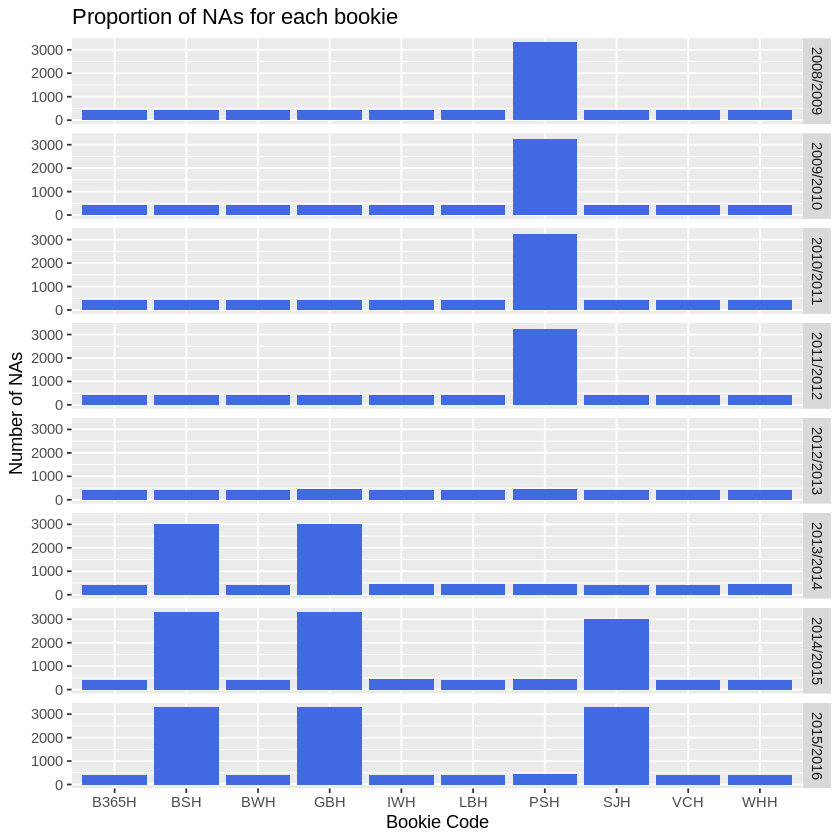

In [0]:
df_bookie_na <- dfs[[3]] %>% 
    select(season, 86:length(colnames(dfs[[3]]))) %>% 
    group_by(season) %>% 
    summarise_all(list(~ sum(is.na(.)))) %>% 
    select(season, ends_with("H")) %>% 
    gather(B365H:BSH, key="key", value="cases") %>% 
    arrange(season)

ggplot(df_bookie_na, aes(x=key, y=cases)) + 
    geom_bar(stat="identity", fill="royal blue") + 
    facet_grid(season ~ .) + 
    ggtitle("Proportion of NAs for each bookie") + 
    xlab("Bookie Code") + 
    ylab("Number of NAs")

In [0]:
schmeckles <- dfs[[3]] %>% 
    select(season, 86:length(colnames(dfs[[3]]))) %>% 
    mutate(num_na=apply(., 1, function(x) sum(is.na(x)))) %>%
    group_by(season) %>%
    summarise_each(list(~max(.), ~min(.), ~mean(.), ~median(.), 
                        ~sd(.), ~sum(.), ~sum(.)/mean(.)), num_na)
prop_ofNa_rows <- schmeckles[[7]]/nrow(dfs[[3]])                        

The above shows a summary of the number of NA values per row under the Bookie columns.

Given that there are 30 columns (10 bookies with 3 odds for each bookie), These results imply that the NA values aren't clustered to the same rows. This makes it likely that if we remove every row with a NA value in it we will have significantly less rows leftover. So I think we should avoid training by all Bookie odds since it reduces our dataset size significantly. 

But we can try using only one set of Bookie's odds.
From the graph showing number of NA's per season for each bookie we can automatically assume that B365H, BWH, IWH, LBH, VCH, WHH are the bookies with fewest NA values.

Once again, we will only remove the NAs later.

Check if cleaning was correct. There should be no more NAs except in *Match* table.

In [0]:
for (i in 1:length(dfs)) {
    print(table_names[i])
    dfs[[i]] %>% 
        summarise_all(list(~ sum(is.na(.)))) %>% 
        select_if(.>0) %>% 
        print
}

[1] "Country"
# A tibble: 1 x 0
[1] "League"
# A tibble: 1 x 0
[1] "Match"
# A tibble: 1 x 104
  home_player_X1 home_player_X2 home_player_X3 home_player_X4 home_player_X5
           <int>          <int>          <int>          <int>          <int>
1           1821           1821           1832           1832           1832
# … with 99 more variables: home_player_X6 <int>, home_player_X7 <int>,
#   home_player_X8 <int>, home_player_X9 <int>, home_player_X10 <int>,
#   home_player_X11 <int>, away_player_X1 <int>, away_player_X2 <int>,
#   away_player_X3 <int>, away_player_X4 <int>, away_player_X5 <int>,
#   away_player_X6 <int>, away_player_X7 <int>, away_player_X8 <int>,
#   away_player_X9 <int>, away_player_X10 <int>, away_player_X11 <int>,
#   home_player_Y1 <int>, home_player_Y2 <int>, home_player_Y3 <int>,
#   home_player_Y4 <int>, home_player_Y5 <int>, home_player_Y6 <int>,
#   home_player_Y7 <int>, home_player_Y8 <int>, home_player_Y9 <int>,
#   home_player_Y10 <int>, home_player

### Further Cleaning<a name="clean"></a>
[(back to top)](#top)

*id* column in the *Country* table should be named *country_id*.

In fact, having 2 separate tables *Country* and *League* is unnecessary. We will combine them. This makes *league_id* column in *Match* table redundant, we shall remove it.

In [0]:
dfs[[1]] <- dfs[[1]] %>% 
    mutate(temp_id=row_number(), league_name=dfs[[2]]$name) %>% 
    select(id=temp_id, country_id=id, 
           country_name=name, league_name=league_name)

dfs[[2]] <- NULL
table_names <- table_names[-2]

#dfs[[2]] <- dfs[[2]] %>% 
   # select(-league_id)

Convert date *chr* columns into more useful data types.

In [0]:
#dfs[[2]] <- dfs[[2]] %>% 
 #   mutate(season=as.integer(substr(season, 1, 4))) %>% 
  #  rename(season_start=season)

dfs[[3]] <- dfs[[3]] %>% 
    mutate(birthday=as.Date(birthday))

for (i in 1:length(dfs)) {
    if ("date" %in% names(dfs[[i]])) {
        dfs[[i]] <- dfs[[i]] %>% 
            mutate(date=as.Date(date))
    }
}

Lets check if each team and player has only 1 entry of attributes.

In [0]:
dfs[[6]] %>% 
    group_by(team_api_id) %>% 
    summarise(count=n()) %>% 
    arrange(desc(count)) %>% 
    head %>% 
    print

dfs[[4]] %>% 
    group_by(player_api_id) %>% 
    summarise(count=n()) %>% 
    arrange(desc(count)) %>% 
    head %>% 
    print

# A tibble: 6 x 2
  team_api_id count
        <int> <int>
1        1601     6
2        1957     6
3        2182     6
4        6403     6
5        7819     6
6        7841     6
# A tibble: 6 x 2
  player_api_id count
          <int> <int>
1         41269    56
2        210278    56
3         26472    54
4         41890    53
5        179795    53
6         25772    51


That's clearly not the case.

We have 2 options to deal with this:
1. Take the latest entry based on date. (**CURRENT**)
2. Take the average of each column.

In [0]:
dfs[[6]] <- dfs[[6]] %>% 
    group_by(team_api_id) %>% 
    filter(date==max(date)) %>% 
    ungroup

dfs[[4]] <- dfs[[4]] %>% 
    group_by(player_api_id) %>% 
    filter(date==max(date)) %>% 
    ungroup

We noticed that *defensive_work_rate* column in *Player_Attributes* table has nonsensical values. Let's verify it.

In [0]:
unique(dfs[[4]]$defensive_work_rate)

[1] "medium" "high"   "_0"     "5"      "low"    "ean"    "o"      "1"     
 [9] "ormal"  "7"      "2"      "8"      "4"      "tocky"  "0"      "3"     
[17] "6"      "9"      "es"

We shall just remove the column to prevent unnecessary explosion of dummy variables.

In [0]:
dfs[[4]] <- dfs[[4]] %>% 
    select(-defensive_work_rate)

Reset the *id* to be the row number.

In [0]:
for (i in 1:length(dfs)) {
    dfs[[i]] <- dfs[[i]] %>% 
        mutate(id=row_number())
}

Final data frames.

In [0]:
for (i in 1:length(dfs)) {
    print(table_names[i])
    print(dfs[[i]])
}

[1] "Country"
# A tibble: 11 x 4
      id country_id country_name league_name             
   <int>      <int> <chr>        <chr>                   
 1     1          1 Belgium      Belgium Jupiler League  
 2     2       1729 England      England Premier League  
 3     3       4769 France       France Ligue 1          
 4     4       7809 Germany      Germany 1. Bundesliga   
 5     5      10257 Italy        Italy Serie A           
 6     6      13274 Netherlands  Netherlands Eredivisie  
 7     7      15722 Poland       Poland Ekstraklasa      
 8     8      17642 Portugal     Portugal Liga ZON Sagres
 9     9      19694 Scotland     Scotland Premier League 
10    10      21518 Spain        Spain LIGA BBVA         
11    11      24558 Switzerland  Switzerland Super League
[1] "Match"
# A tibble: 25,979 x 115
      id country_id league_id season stage date       match_api_id
   <int>      <int>     <int> <chr>  <int> <date>            <int>
 1     1          1         1 2008/…     1

## Exploratory Data Analysis<a name="eda"></a>
[(back to top)](#top)


In [0]:
match = dfs[2]

new_match <- data.frame(lapply(match, function(x) x%>% select('id', 'country_id', 'league_id', 'stage', 'date',
                   'match_api_id', 'home_team_api_id', 'away_team_api_id',
                    'home_team_goal', 'away_team_goal','season')))

In [0]:
key_team <- data.frame(country_id=dfs[[1]]$country_id, 
                       league_name=dfs[[1]]$league_name)
new_match <- new_match %>%
    full_join(key_team, by='country_id') 
head(new_match)

id,country_id,league_id,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,league_name
<int>,<int>,<int>,<int>,<date>,<int>,<int>,<int>,<int>,<int>,<chr>,<fct>
1,1,1,1,2008-08-17,492473,9987,9993,1,1,2008/2009,Belgium Jupiler League
2,1,1,1,2008-08-16,492474,10000,9994,0,0,2008/2009,Belgium Jupiler League
3,1,1,1,2008-08-16,492475,9984,8635,0,3,2008/2009,Belgium Jupiler League
4,1,1,1,2008-08-17,492476,9991,9998,5,0,2008/2009,Belgium Jupiler League
5,1,1,1,2008-08-16,492477,7947,9985,1,3,2008/2009,Belgium Jupiler League
6,1,1,1,2008-09-24,492478,8203,8342,1,1,2008/2009,Belgium Jupiler League


#### Home and Away Goals Scored<a name="scored-eda"></a>
[(back to top)](#top)

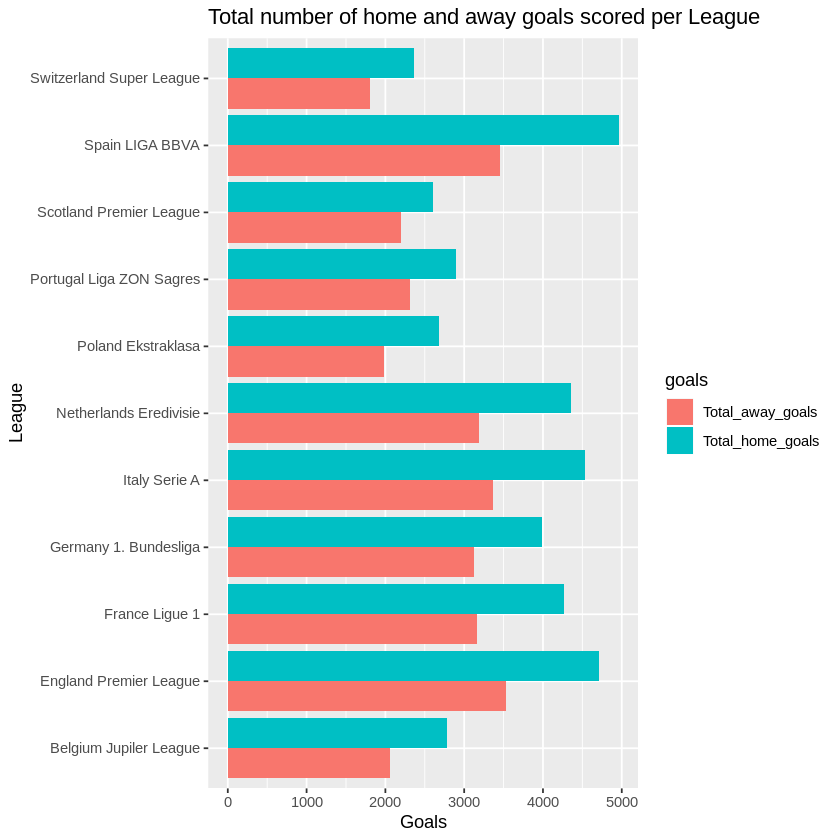

In [0]:

away_goals <- aggregate(new_match$away_team_goal, by=list(League=new_match$league_name), FUN=sum)
home_goals <- aggregate(new_match$home_team_goal, by=list(League=new_match$league_name), FUN=sum)


total_league_goals <- merge(home_goals,away_goals, by = 'League')

colnames(total_league_goals) <- c("League", "Total_home_goals", "Total_away_goals")

total_league_goals <- gather(total_league_goals,goals,total,Total_home_goals:Total_away_goals)

plot <- ggplot(total_league_goals, aes(x = League, y = total, fill=goals))
plot <- plot + geom_bar(stat = "identity", position = 'dodge')+coord_flip()
plot + labs(x="League",y="Goals")+ggtitle("Total number of home and away goals scored per League")

#### Top 20 Team Scores<a name="score-eda"></a>
[(back to top)](#top)

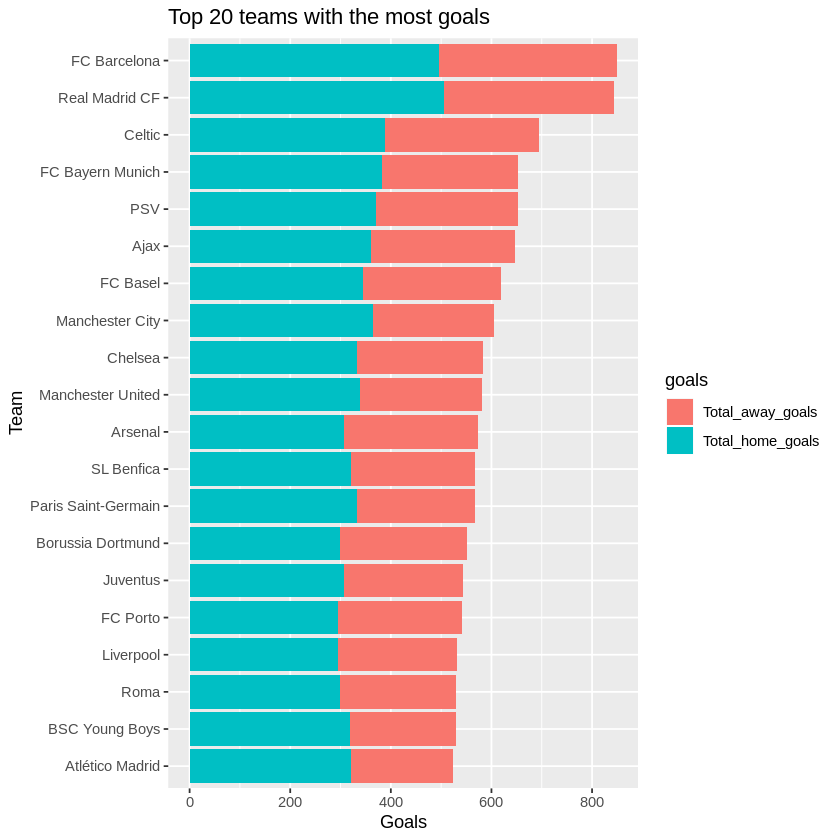

In [0]:

key_team_namehome <- data.frame(home_team_api_id = dfs[[5]]$team_api_id, team_name = dfs[[5]]$team_long_name)

home_teamgoals <- new_match[c('home_team_api_id','home_team_goal')]


home_teamgoals <- home_teamgoals %>%
  full_join(key_team_namehome, by = 'home_team_api_id') 



key_team_nameaway <- data.frame(away_team_api_id = dfs[[5]]$team_api_id, team_name = dfs[[5]]$team_long_name)

away_teamgoals <- new_match[c('away_team_api_id','away_team_goal')]


away_teamgoals <- away_teamgoals %>%
  full_join(key_team_nameaway, by = 'away_team_api_id') 

away_teamgoals <- aggregate(away_teamgoals$away_team_goal, by=list(Team = away_teamgoals$team_name), FUN=sum)

home_teamgoals <- aggregate(home_teamgoals$home_team_goal, by=list(Team = home_teamgoals$team_name), FUN=sum)



total_team_goals <- merge(home_teamgoals,away_teamgoals, by = 'Team')


colnames(total_team_goals) <- c("Team", "Total_home_goals", "Total_away_goals")

total_team_goals$combined_goals <- rowSums(total_team_goals[c('Total_home_goals','Total_away_goals')])

top20goals <- (total_team_goals[order(-total_team_goals$combined_goals),])[1:20,]

top20goals <- gather(top20goals,goals,total,Total_home_goals:Total_away_goals)


plot2 <- ggplot(top20goals, aes(x = reorder(Team, combined_goals), y = total, fill=goals))
plot2 <- plot2 + geom_bar(stat = "identity", position = 'stack')+coord_flip()
plot2 + labs(x="Team",y="Goals")+ggtitle("Top 20 teams with the most goals")

#### Top 20 Team Wins<a name="win-eda"></a>
[(back to top)](#top)

In [0]:
label_wld <- function(data){
wld = c()
  for(i in 1: nrow(data)){
    if (data[i,'home_team_goal'] < data[i,'away_team_goal']){
        wld = c(wld,toString(data[i,'away_team_name']))
      }
    if(data[i,"away_team_goal"] < data[i,'home_team_goal']){
        wld = c(wld,toString(data[i,'home_team_name']))
      }
    if( data[i,'home_team_goal']== data[i,'away_team_goal']){
        wld = c(wld,"Draw")
      }
    }
  return (wld)
  }

In [0]:
all_teamgoals <- new_match[c('home_team_api_id', 'home_team_goal', 
                             'away_team_api_id', 'away_team_goal')]
key_team_name_home <- data.frame(home_team_api_id=dfs[[5]]$team_api_id, 
                                 home_team_name=dfs[[5]]$team_long_name)
key_team_name_away <- data.frame(away_team_api_id=dfs[[5]]$team_api_id, 
                                 away_team_name=dfs[[5]]$team_long_name)


all_teamgoals <- all_teamgoals %>%
  full_join(key_team_name_home, by='home_team_api_id') 


all_teamgoals <- all_teamgoals %>%
  full_join(key_team_name_away, by='away_team_api_id') 


all_teamgoals <- all_teamgoals %>%
   select(-c('home_team_api_id', 'away_team_api_id'))


wld = data.frame(wld = label_wld(all_teamgoals))
all_teamgoals <- cbind(all_teamgoals,wld)



In [0]:
sum_wld <- data.frame(Team = unique(all_teamgoals$home_team_name,stringsAsFactors = FALSE))
Win <- numeric(length(sum_wld))
Lose <- numeric(length(sum_wld))
Draw <- numeric(length(sum_wld))
sum_wld <- cbind(sum_wld, Win, Lose, Draw)

for(i in 1:nrow(all_teamgoals)){
  ht = toString(all_teamgoals[i,]$home_team_name)
  at = toString(all_teamgoals[i,]$away_team_name)
  if(all_teamgoals[i,]$wld == ht){
    sum_wld[sum_wld$Team == ht,]$Win = 1 +sum_wld[sum_wld$Team == ht,]$Win
    sum_wld[sum_wld$Team == at,]$Lose = 1+  sum_wld[sum_wld$Team == at,]$Lose 
  }
   if(all_teamgoals[i,]$wld == at){
    sum_wld[sum_wld$Team == at,]$Win = 1 + sum_wld[sum_wld$Team == at,]$Win
    sum_wld[sum_wld$Team == ht,]$Lose = 1 + sum_wld[sum_wld$Team == ht,]$Lose 
  }
  else{
     sum_wld[sum_wld$Team == at,]$Draw = 1 + sum_wld[sum_wld$Team == at,]$Draw 
     sum_wld[sum_wld$Team == ht,]$Draw = 1 + sum_wld[sum_wld$Team == ht,]$Draw 
  }
}

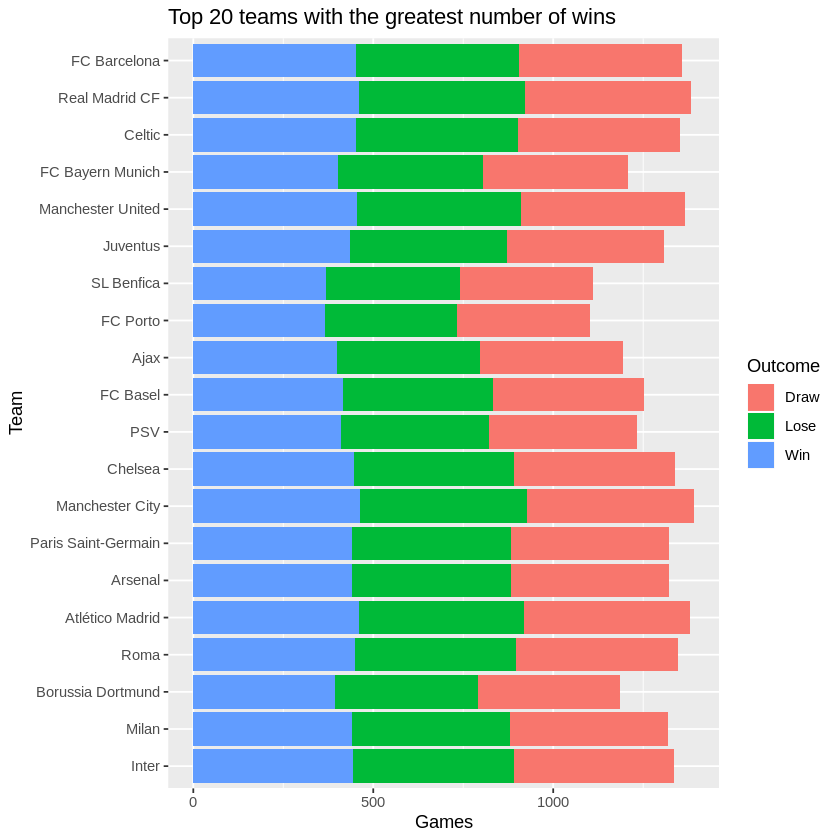

In [0]:
order_sumwld <- sum_wld[with(sum_wld,order(-Win,-Draw,-Lose)),]
order_sumwld_top20 <- order_sumwld[1:20,]
order_sumwld_top20$rank <- 1:20

order_sumwld_top20$combined_games <- rowSums(order_sumwld_top20[c('Win','Draw','Lose')])


order_sumwld_top20 <- gather(order_sumwld_top20,Outcome,game,c(Win,Lose,Draw))

plot6 <- ggplot(order_sumwld_top20, aes(x = reorder(Team,-rank),y= combined_games, fill = Outcome))
plot6 <- plot6 + geom_bar(stat = "identity", position = 'stack')+coord_flip()+ labs(x="Team",y="Games")+ggtitle("Top 20 teams with the greatest number of wins")

plot6 




#### Distribution of Goals <a name="goal-eda"></a>
[(back to top)](#top)

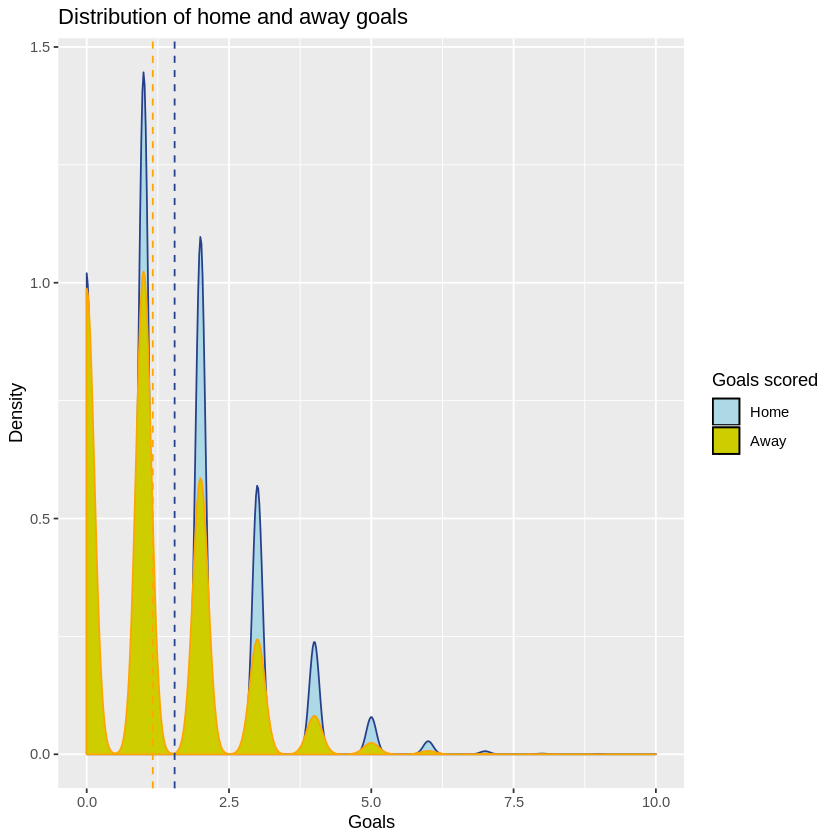

In [0]:
plot3 <- ggplot(new_match) + 
  geom_density(aes(x = home_team_goal,fill ="lightblue",col = "royalblue4")) +
geom_density(aes(x=away_team_goal,fill = "yellow3",col = "orange"))+ ggtitle("Distribution of home and away goals")+
labs(x = "Goals", y = "Density") +  scale_fill_identity(name = 'Goals scored', labels = c("Home","Away"), guide = "legend")+
scale_colour_identity(name = "Goal scored", labels = c("Home","Away")) + geom_vline(aes(xintercept = mean(home_team_goal), col = "royalblue4"), linetype = "dashed")+
geom_vline(aes(xintercept = mean(away_team_goal), col = "orange"), linetype = "dashed")


plot3

#### Goals Scored per Season <a name="season-eda"></a>
[(back to top)](#top)

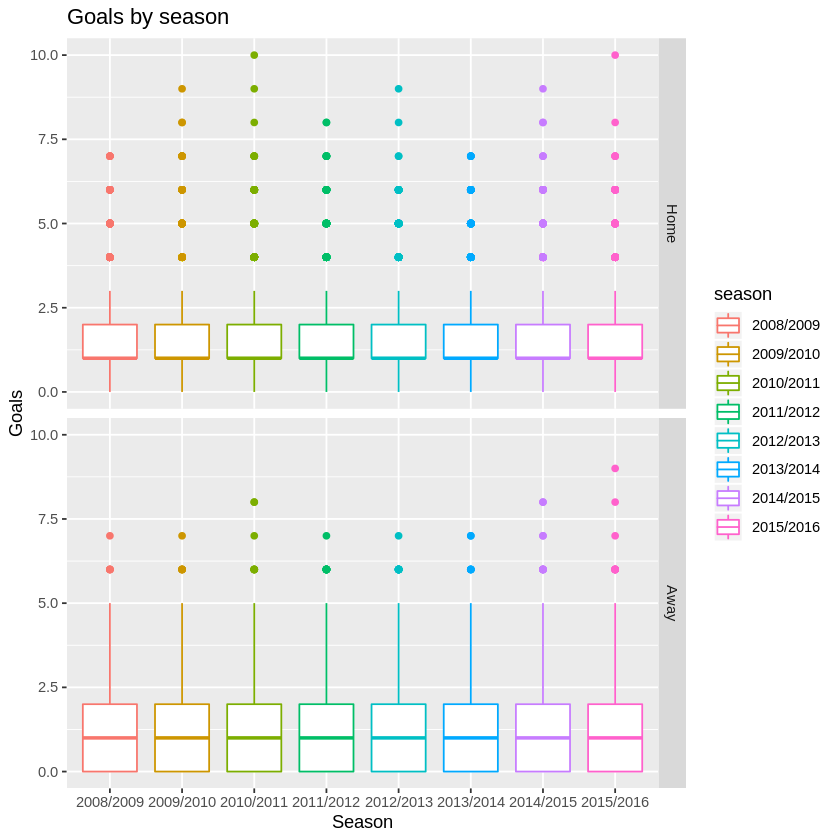

In [0]:
season_goals <- gather(new_match,score,goals,home_team_goal:away_team_goal)
season_goals$score <- factor(season_goals$score, levels = c("home_team_goal","away_team_goal"),labels = c("Home","Away"))

plot4 <- ggplot(season_goals,aes(x=season, y=goals)) + geom_boxplot(aes(col = season)) +
facet_grid(score~. )+ ggtitle("Goals by season") + labs(y = "Goals", x = "Season")

plot4

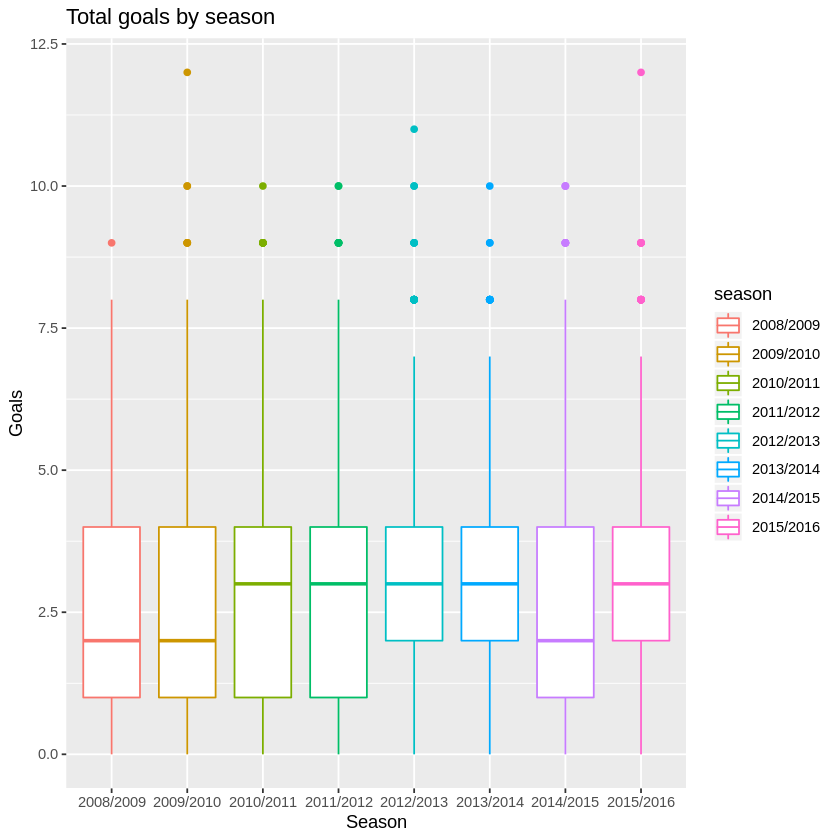

In [0]:
season_combined_goals <- new_match[c('season','home_team_goal','away_team_goal')]
season_combined_goals$combined_goals <- rowSums(season_combined_goals[c('home_team_goal','away_team_goal')])

plot5 <- ggplot(season_combined_goals,aes(x=season, y=combined_goals)) + geom_boxplot(aes(col = season)) + ggtitle("Total goals by season") + labs(y = "Goals", x = "Season")
plot5

#### Total Goals Scored per Season <a name="top_goals-eda"></a>
[(back to top)](#top)

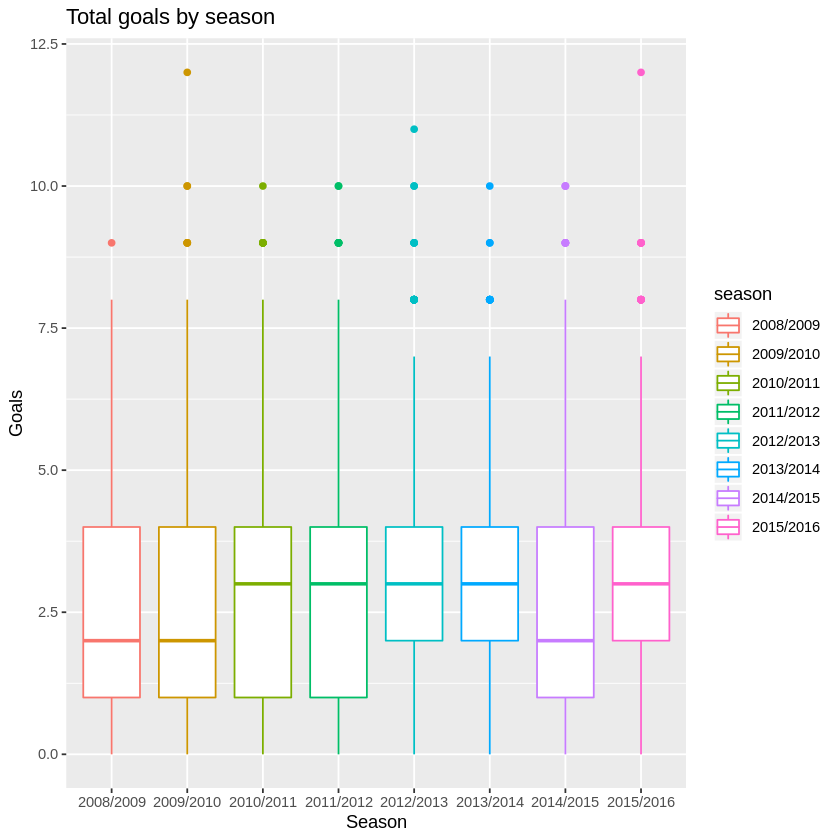

In [0]:
season_combined_goals <- new_match[c('season','home_team_goal','away_team_goal')]
season_combined_goals$combined_goals <- rowSums(season_combined_goals[c('home_team_goal','away_team_goal')])

plot5 <- ggplot(season_combined_goals,aes(x=season, y=combined_goals)) + geom_boxplot(aes(col = season)) + ggtitle("Total goals by season") + labs(y = "Goals", x = "Season")
plot5

In [0]:
dfs[[2]] <- dfs[[2]] %>% 
   select(-league_id)

dfs[[2]] <- dfs[[2]] %>% 
   mutate(season=as.integer(substr(season, 1, 4))) %>% 
  rename(season_start=season)

#part of the data cleaning that i did not use 


## Predicting Match Results<a name="pred_res"></a>

### Problem Formulation<a name="form-pred_res"></a>
[(back to top)](#top)

We want to predict the winner of the match (*Home*, *Away*, or *Draw*) based on attributes of players and teams. This is thus be a classification problem with a 3 level categorical target.

We start by removing betting odds statistics, match statistics, and NAs in *Match* table.

Next, we'll join the relevant tables into a giant table which we will be training the model on.

Since the players are already sorted by the Y position, we can remove the X and Y coordinates of the players (unless we have a better idea of utilizing this information).

To track data size after every operation:
1. Original *Match* table: 25,979 x 114
2. After removing statistics and NAs: 21,361 × 76
3. After joining *Team_Attributes*: 21,233 × 116
4. After joining *Player_Attributes*: 18,850 × 908
5. After removing unnecessary columns: 18,850 × 833
6. After one-hot encoding: 18,850 × 851

In [0]:
# Remove statistics and NAs
df <- dfs[[2]][, 1:76]
df <- df[complete.cases(df), ]

# Join Team_Attributes table
df_team <- dfs[[6]] %>% 
    select(-c(id, date, team_fifa_api_id))
df_home <- df_team
names(df_home) <- paste0(names(df_home), "Home")
df_away <- df_team
names(df_away) <- paste0(names(df_away), "Away")

df <- df %>% 
    inner_join(df_home, by=c("home_team_api_id"="team_api_idHome")) %>% 
    inner_join(df_away, by=c("away_team_api_id"="team_api_idAway"))

# Join Player_Attributes table
df_player <- dfs[[4]] %>% 
    select(-c(id, date, player_fifa_api_id))
player_names <- names(df_player)
for (i in 1:11) {
    # Dynamically create named vector to match joining columns
    home_key <- paste0("home_player_", i)
    join_home <- paste0("player_api_id_home_", i)
    away_key <- paste0("away_player_", i)
    join_away <- paste0("player_api_id_away_", i)
    names(join_home) <- home_key
    names(join_away) <- away_key

    # Join tables
    names(df_player) <- paste0(player_names, "_home_", i)
    df <- inner_join(df, df_player, by=join_home)
    names(df_player) <- paste0(player_names, "_away_", i)
    df <- inner_join(df, df_player, by=join_away)
}

# Replace country_id with country_name
df_country <- dfs[[1]] %>% 
    select(country_id, country_name)
df <- df %>% 
    inner_join(df_country, by="country_id")

# Convert home_team_goal and away_team_goal into a single column
df <- df %>% 
    mutate(winner=home_team_goal-away_team_goal) %>% 
    mutate(winner=ifelse(winner==0, "Draw", 
                         ifelse(winner>0, "Home", "Away")))

# Remove columns unnecessary for prediction
to_remove <- c("id", "country_id", "season_start", "date", "country_name", 
               "home_team_goal", "away_team_goal", "stage", 
               paste0(c("match", "home_team", "away_team"), "_api_id"), 
               paste0("home_player_", 1:11), paste0("away_player_", 1:11), 
               paste0("home_player_X", 1:11), paste0("away_player_X", 1:11), 
               paste0("home_player_Y", 1:11), paste0("away_player_Y", 1:11))
df <- select(df, -to_remove)

#### Process data<a name="pd-pred_res"></a>
[(back to top)](#top)

Scale continuous features and dummy encode categorical features. Split into training and testing datasets for prediction.

In [0]:
# Set aside target variable
y <- factor(df$winner, levels=c("Draw", "Home", "Away"))

# Convert character columns in factors
df_ctgy <- df %>% 
    select(-winner) %>% 
    select_if(is.character) %>% 
    mutate_all(as.factor)

# Scale continuous features to [0, 1]
df_cont <- df %>% 
    select_if(is.integer) %>% 
    mutate_all(function(x) (x - min(x)) / (max(x) - min(x)))
cont_features <- names(df_cont)

# Dummy encode categorical features
mat_ctgy <- model.matrix(~., df_ctgy)
mat_ctgy <- mat_ctgy[, 2:ncol(mat_ctgy)]

# Combine into data frame
df_final <- cbind(df_cont, mat_ctgy, winner=y) %>% 
    as_tibble
id <- 1:nrow(df_final)#finn included this to allow for indexing of rows
ctgy_features <- setdiff(names(df_final), cont_features) %>% 
    setdiff("winner")

# Get split indices
train_prop <- 0.8
train_size <- floor(train_prop * nrow(df_final))
train_ind <- sample(1:nrow(df_final), size=train_size)

# Split data frame
df_train <- df_final[train_ind,]
df_test <- df_final[-train_ind,]
id_test <- id[-train_ind]#finn included this to allow for indexing of rows

### Dimensionality Reduction<a name="dim_red-pred_res"></a>

#### Principal Component Analysis<a name="pca-pred_res"></a>
[(back to top)](#top)

Lets start by splitting categorical and continuous features.

In [0]:
df_cont <- df_train %>% 
    select(cont_features)

Number of continuous features: 786

Number of categorical features: 64

We shall focus on reducing the dimensions of the continuous features.

Lets take a look at the correlation plot too see if we can expect decent results from using PCA. Since there are too many variables to plot, we will only plot a subset of variables.

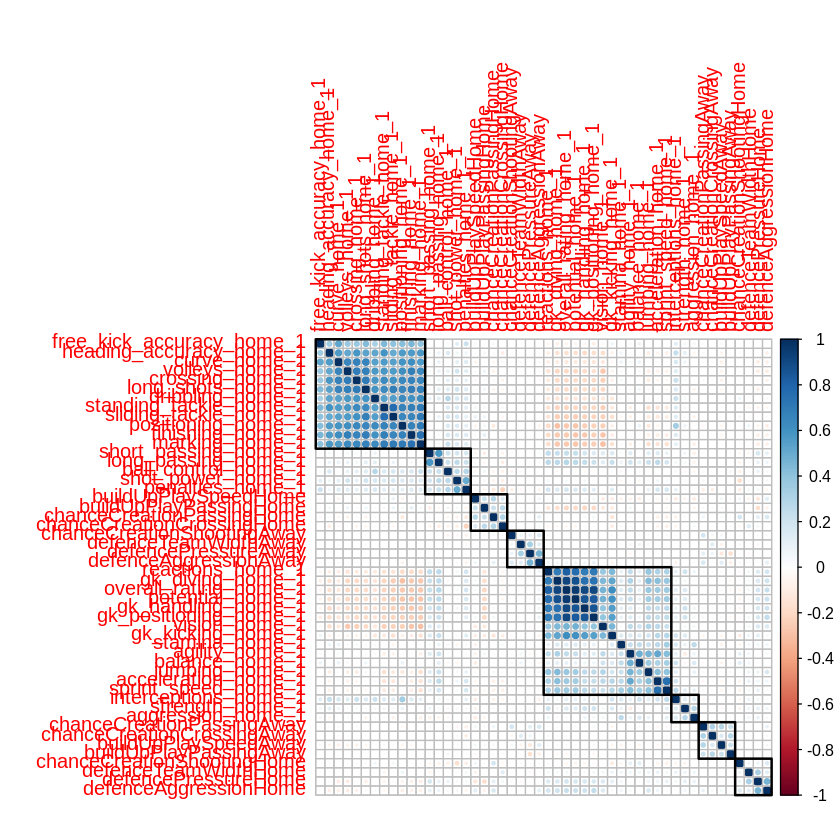

In [0]:
corrplot(cor(df_cont[, 1:50]), order="hclust", addrect=8)

It does seem like there are clusters of highly correlated variables that can be "combined" using PCA.

We will create the pca model and use a scree plot to decide the number of components to use.

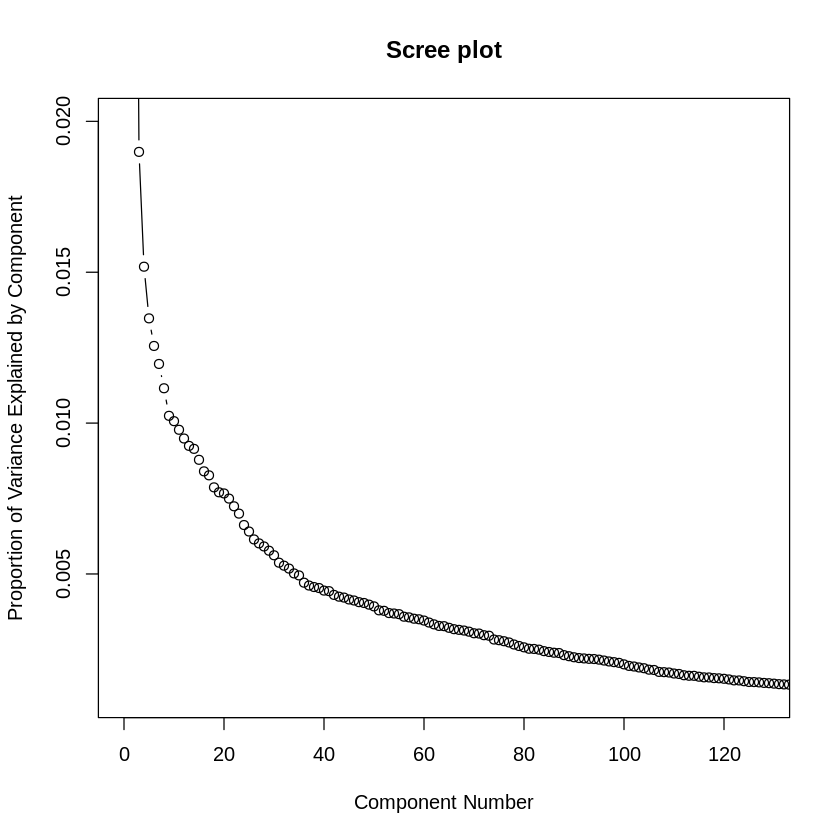

In [0]:
# Create PCA model
pca_model <- prcomp(df_cont, scale.=TRUE)

# Create scree plot
pr_var <- pca_model$sdev^2
prop_var_explained <- pr_var/sum(pr_var)
plot(prop_var_explained, 
    main="Scree plot", 
    xlab="Component Number", 
    ylab="Proportion of Variance Explained by Component", 
    xlim=c(0, 128), 
    ylim=c(0.001, 0.02), 
    type="b")

Based on the scree plot, we can use the top 35 components to have the majority of the variance explained.

In [0]:
num_comp <- 35
mat_cont <- pca_model$x[, 1:num_comp]

# Reduced training dataset
df_ctgy <- df_train %>% 
    select(ctgy_features)
df_red_train <- cbind(mat_cont, df_ctgy, winner=df_train$winner) %>% 
    as_tibble

# Reduce testing dataset
df_cont <- df_test %>% 
    select(cont_features)
mat_cont <- predict(pca_model, newdata=df_cont)[, 1:num_comp]
df_ctgy <- df_test %>% 
    select(ctgy_features)
df_red_test <- cbind(mat_cont, df_ctgy, winner=df_test$winner) %>% 
    as_tibble

Final dataset sizes:
* *df_train*: 15,080 × 851
* *df_test*: 3,770 × 851
* *df_red_train*: 15,080 × 100
* *df_red_test*: 3,770 × 100

Visualize decision boundary

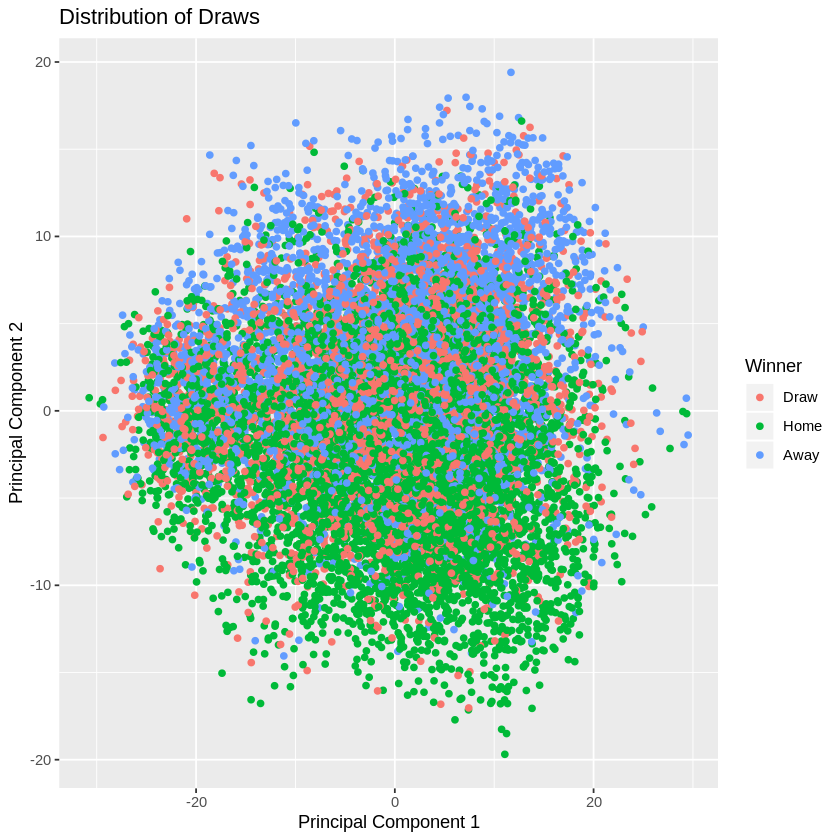

In [0]:
df_vis <- pca_model$x[, 1:num_comp] %>% 
    as_tibble %>% 
    mutate(Winner=df_train$winner)

ggplot(df_vis) + 
    geom_point(aes(x=PC1, y=PC2, col=Winner)) + 
    ggtitle("Distribution of Draws") + 
    xlab("Principal Component 1") + 
    ylab("Principal Component 2")

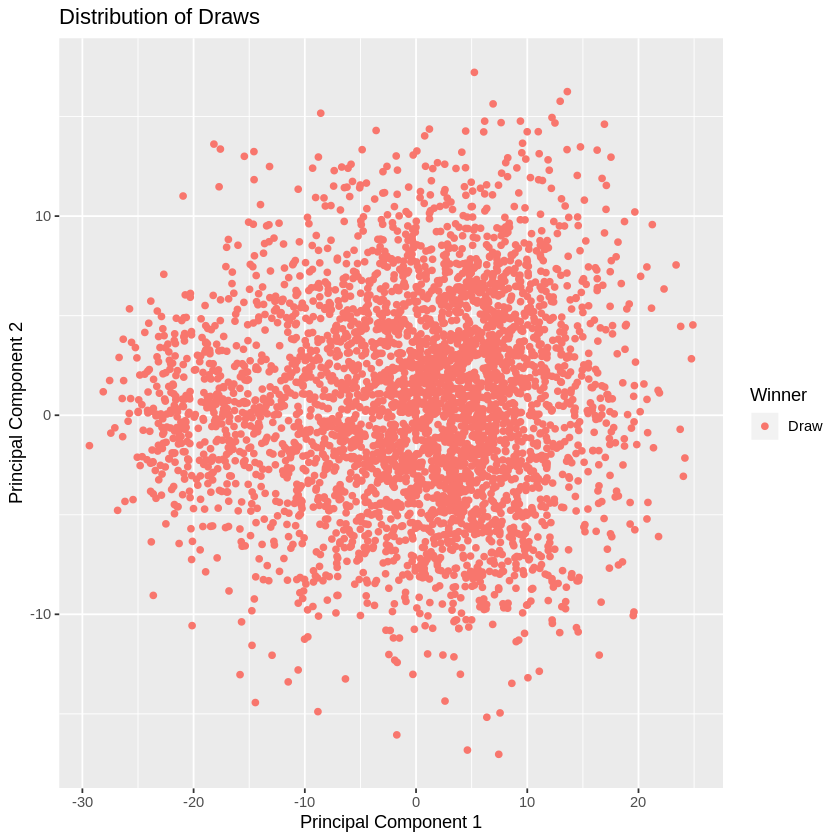

In [0]:
df_vis <- pca_model$x[, 1:num_comp] %>% 
    as_tibble %>% 
    mutate(Winner=df_train$winner) %>% 
    filter(Winner=="Draw")

ggplot(df_vis) + 
    geom_point(aes(x=PC1, y=PC2, col=Winner)) + 
    ggtitle("Distribution of Draws") + 
    xlab("Principal Component 1") + 
    ylab("Principal Component 2")

### Multiclass Classification<a name="class-pred_res"></a>

#### Multinomial Logistic Regression<a name="mlr-pred_res"></a>
[(back to top)](#top)

Train models and time how long it takes to train them.

In [0]:
start_time <- Sys.time()
mlr_model <- multinom(winner~., data=df_train, maxit=1024, MaxNWts=10000)
end_time <- Sys.time()
writeLines(paste("Time taken:", end_time-start_time, "min\n"))

start_time <- Sys.time()
mlr_red_model <- multinom(winner~., data=df_red_train, maxit=1024, MaxNWts=10000)
end_time <- Sys.time()
writeLines(paste("Time taken:", end_time-start_time, "sec"))
#save(mlr_model, file = "./tmp/model_multinom.rda")#finn made it so you can save the model 
#mlr_model <- get(load(file = "./tmp/model_multinom.rda"))#finn made it so you can save the model (: (:(:

# weights:  2556 (1702 variable)
initial  value 16567.073313 
iter  10 value 14262.290969
iter  20 value 13955.273915
iter  30 value 13863.005976
iter  40 value 13811.653537
iter  50 value 13767.654483
iter  60 value 13739.805146
iter  70 value 13720.815044
iter  80 value 13708.442822
iter  90 value 13699.452624
iter 100 value 13693.590527
iter 110 value 13690.436513
iter 120 value 13689.540393
iter 130 value 13689.320798
iter 140 value 13689.251578
iter 150 value 13689.202777
iter 160 value 13689.139135
iter 170 value 13689.089067
iter 180 value 13689.070339
iter 190 value 13689.064817
final  value 13689.062911 
converged
Time taken: 1.94898130496343 min

# weights:  303 (200 variable)
initial  value 16567.073313 
iter  10 value 15490.641813
iter  20 value 15444.761231
iter  30 value 15417.602759
iter  40 value 15373.463267
iter  50 value 15302.726370
iter  60 value 15177.981115
iter  70 value 15020.950951
iter  80 value 14956.940030
iter  90 value 14881.435005
iter 100 value 14753.20

Evaluate model trained on original data.

In [0]:
message <- "TRAIN SCORE\nF1 score:"
y_pred <- predict(mlr_model, type="class", newdata=df_train)
writeLines(paste(message, F1_Score(y_pred, df_train$winner)))
confusionMatrix(y_pred, df_train$winner)

message <- "-----------------------------------------------------------------\n
TEST SCORE\nF1 score:"
y_pred <- predict(mlr_model, type="class", newdata=df_test)
writeLines(paste(message, F1_Score(y_pred, df_test$winner)))
confusionMatrix(y_pred, df_test$winner)

TRAIN SCORE
F1 score: 0.288386869043417


Confusion Matrix and Statistics

          Reference
Prediction Draw Home Away
      Draw  817  561  458
      Home 2026 5424 1500
      Away  987  937 2370

Overall Statistics
                                          
               Accuracy : 0.571           
                 95% CI : (0.5631, 0.5789)
    No Information Rate : 0.459           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3024          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: Draw Class: Home Class: Away
Sensitivity              0.21332      0.7836      0.5476
Specificity              0.90942      0.5678      0.8211
Pos Pred Value           0.44499      0.6060      0.5519
Neg Pred Value           0.77250      0.7556      0.8185
Prevalence               0.25398      0.4590      0.2870
Detection Rate           0.05418      0.3597      0.1572
Detection Prev

-----------------------------------------------------------------

TEST SCORE
F1 score: 0.180918727915194


Confusion Matrix and Statistics

          Reference
Prediction Draw Home Away
      Draw  128  188  156
      Home  546 1269  450
      Away  269  249  515

Overall Statistics
                                          
               Accuracy : 0.5072          
                 95% CI : (0.4911, 0.5232)
    No Information Rate : 0.4525          
    P-Value [Acc > NIR] : 9.871e-12       
                                          
                  Kappa : 0.1991          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: Draw Class: Home Class: Away
Sensitivity              0.13574      0.7438      0.4594
Specificity              0.87832      0.5174      0.8045
Pos Pred Value           0.27119      0.5603      0.4985
Neg Pred Value           0.75288      0.7096      0.7786
Prevalence               0.25013      0.4525      0.2973
Detection Rate           0.03395      0.3366      0.1366
Detection Prev

In [0]:
model_test <- coeftest(mlr_model)

In [0]:
p_values <- model_test[, 4]
mat_coef <- model_test[, 1:4]
df_coef <- as_tibble(mat_coef) %>% 
    mutate(Feature=str_sub(rownames(mat_coef), 6), 
           Class=factor(tolower(str_sub(rownames(mat_coef), 1, 4)), 
                        levels=c("home", "away")), 
           Team=ifelse(grepl("home|Home", Feature), "home", "away")) %>% 
    filter(Feature!="(Intercept)") %>% 
    mutate(Feature=as.factor(Feature))

df_coef %>% 
    filter(!!as.name(names(df_coef)[4])<0.005)

Estimate,Std. Error,z value,Pr(>|z|),Feature,Class,Team
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<chr>
0.8415330,0.2723059,3.090396,0.0019988958,balance_home_5,home,home
-0.4364237,0.1443991,-3.022343,0.0025082608,gk_reflexes_away_5,home,away
2.1107971,0.7314450,2.885791,0.0039043168,overall_rating_home_9,home,home
0.6394740,0.2081904,3.071583,0.0021292675,free_kick_accuracy_home_2,away,home
-0.9793236,0.3313745,-2.955338,0.0031232644,strength_home_2,away,home
1.5144930,0.4587714,3.301193,0.0009627448,potential_home_6,away,home
1.2100928,0.4141863,2.921615,0.0034822182,positioning_away_8,away,away
-2.0482448,0.6018965,-3.402985,0.0006665394,gk_positioning_away_10,away,away


Evaluate model trained on reduced data.

In [0]:
message <- "TRAIN SCORE\nF1 score:"
y_pred <- predict(mlr_red_model, type="class", newdata=df_red_train)
writeLines(paste(message, F1_Score(y_pred, df_red_train$winner)))
confusionMatrix(y_pred, df_red_train$winner)

message <- "-----------------------------------------------------------------\n
TEST SCORE\nF1 score:"
y_pred <- predict(mlr_red_model, type="class", newdata=df_red_test)
writeLines(paste(message, F1_Score(y_pred, df_red_test$winner)))
confusionMatrix(y_pred, df_red_test$winner)

TRAIN SCORE
F1 score: 0.0385947550717467


Confusion Matrix and Statistics

          Reference
Prediction Draw Home Away
      Draw   78   70   64
      Home 2532 5714 1956
      Away 1220 1138 2308

Overall Statistics
                                          
               Accuracy : 0.5371          
                 95% CI : (0.5291, 0.5451)
    No Information Rate : 0.459           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2248          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: Draw Class: Home Class: Away
Sensitivity             0.020366      0.8255      0.5333
Specificity             0.988089      0.4499      0.7807
Pos Pred Value          0.367925      0.5601      0.4946
Neg Pred Value          0.747646      0.7524      0.8060
Prevalence              0.253979      0.4590      0.2870
Detection Rate          0.005172      0.3789      0.1531
Detection Prev

-----------------------------------------------------------------

TEST SCORE
F1 score: 0.034


Confusion Matrix and Statistics

          Reference
Prediction Draw Home Away
      Draw   17   20   20
      Home  633 1401  516
      Away  293  285  585

Overall Statistics
                                          
               Accuracy : 0.5313          
                 95% CI : (0.5152, 0.5473)
    No Information Rate : 0.4525          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2168          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: Draw Class: Home Class: Away
Sensitivity             0.018028      0.8212      0.5219
Specificity             0.985851      0.4433      0.7818
Pos Pred Value          0.298246      0.5494      0.5030
Neg Pred Value          0.750606      0.7500      0.7944
Prevalence              0.250133      0.4525      0.2973
Detection Rate          0.004509      0.3716      0.1552
Detection Prev

#### Random Forest Classifier/Neural Network<a name="rfc-pred_res"></a>
[(back to top)](#top)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘XML’, ‘rpart.plot’


rattle installed


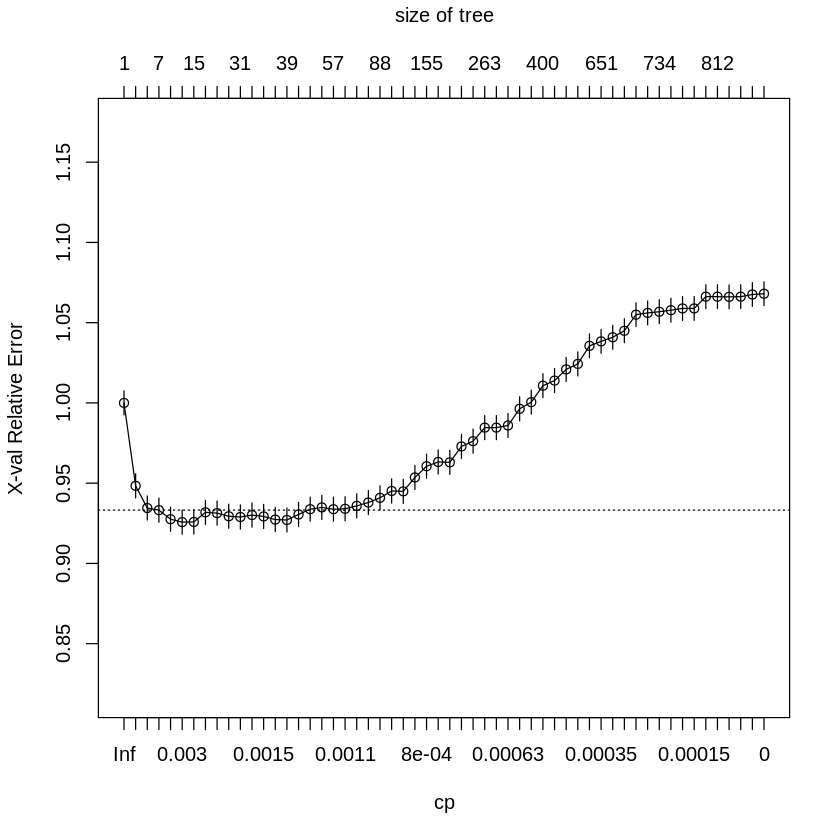

[1] "Tree Avarage Balance Accuracy: 0.563839644122714"

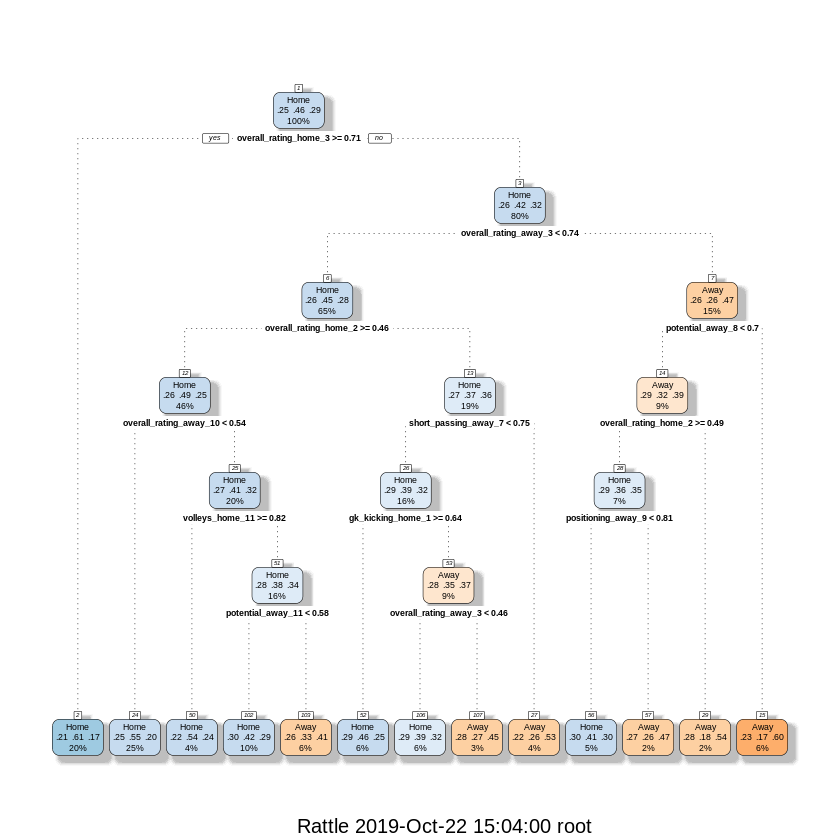

In [0]:
# SINGLE TREE MODEL

#Probably need to install rpart in the beginning?
#import rpart
p_load("rpart")

#Build a classification tree based on the training data. We set the complexity
# parameter (cp) to zero to let the tree fit the training data as well as possible
tree = rpart(factor(df_train$winner)~., df_train, method = 'class', control = list(cp=0))

# Evaluate the performance of this tree on the testing data
tree_preds = predict(tree, df_test, type='class')
tree_confmat <- confusionMatrix(tree_preds, factor(df_test$winner))
tree_byclass = tree_confmat$byClass
sprintf("Unpruned Tree Avarage Balance Accuracy: %s", sum(tree_byclass[,"Balanced Accuracy"])/3)

#generally the tree will overfit the training data, so we now do a cross-validation
# and prune the tree based on the best value of cp (will be >0)
plotcp(tree)
ptree<- prune(tree,cp= tree$cptable[which.min(tree$cptable[,"xerror"]),"CP"])

# the package rattle can be used to make a nice visualization of the tree with fancyRpartPlot
#should also be installed in the beginning
p_load("rattle")
fancyRpartPlot(ptree)

# Now lets see how well the pruned tree does on the test data.
ptree_preds = predict(ptree, df_test, type='class')
ptree_confmat <- confusionMatrix(ptree_preds, factor(df_test$winner))
ptree_byclass = ptree_confmat$byClass
sprintf("Pruned Tree Avarage Balance Accuracy: %s", sum(ptree_byclass[,"Balanced Accuracy"])/3)

In [0]:
# NOW THE RANDOM FOREST
# the random forest is implemented with the package ranger.
# ranger must also be installed
p_load("ranger")

# The ranger package could not handle the original dataframes, so I had to set names to the dataframes like this
ranger_train = df_train
ranger_test = df_test
names(ranger_train) <- make.names(names(ranger_train))
names(ranger_test) <- make.names(names(ranger_test))

# initialize some lists which will store some performance metrics of random forests models with different sizes
balanced_accuracy = c()
ntrees = c()
error_rate = c()

# start with creating a random forest with only one tree and evaluate its performance
BRF <- ranger(factor(ranger_train$winner)~., ranger_train, num.trees = 1)
BRF_preds = predict(BRF, data = ranger_test)
BRF_confmat <- confusionMatrix(BRF_preds$predictions, factor(ranger_test$winner))
BRF_byclass = BRF_confmat$byClass
sprintf("Balanced random forest %s Trees Avarage Balance Accuracy: %s", 1, sum(BRF_byclass[,"Balanced Accuracy"])/3)
balanced_accuracy = c(balanced_accuracy, sum(BRF_byclass[,"Balanced Accuracy"])/3)
ntrees = c(ntrees, 1)
error_rate = c(error_rate, 1-BRF_confmat$overall["Accuracy"])

# Now train and evaluate random forests with ntrees = i*20 with i ranging from 1 to 30.
# We can then plot the error_rate against ntrees
# OBS! This takes some time to run, and it is essentially only used for selecting an appropriate number of trees for the random forest
for(i in 1:30){
  BRF <- ranger(factor(ranger_train$winner)~., ranger_train, num.trees = i*20)
  BRF_preds = predict(BRF, data = ranger_test)
  BRF_confmat <- confusionMatrix(BRF_preds$predictions, factor(ranger_test$winner))
  BRF_byclass = BRF_confmat$byClass
  sprintf("Balanced random forest %s Trees Avarage Balance Accuracy: %s", 20*i, sum(BRF_byclass[,"Balanced Accuracy"])/3)
  balanced_accuracy = c(balanced_accuracy, sum(BRF_byclass[,"Balanced Accuracy"])/3)
  ntrees = c(ntrees, 20*i)
  error_rate = c(error_rate, 1-BRF_confmat$overall["Accuracy"])
}

# plot the error rate against the number of trees in the random forest
plot(x=ntrees, y=error_rate, type='l', col='red')

# 400 trees seems to be enough for the error rate to settle down
# evaluate the performance of the random forest with 400 trees
BRF <- ranger(factor(ranger_train$winner)~., df_train, num.trees = 400)
BRF_preds = predict(BRF, data = ranger_test)
BRF_confmat <- confusionMatrix(BRF_preds$predictions, factor(ranger_test$winner))
BRF_byclass = BRF_confmat$byClass
sprintf("Random forest %s Trees Avarage Balance Accuracy on test set: %s", 400, sum(BRF_byclass[,"Balanced Accuracy"])/3)


#### KNN<a name="rfc-pred_res"></a>
[(back to top)](#top)

KNN with 10 folds CV with K = 1-250 

In [0]:
library(class)
library(caret)

fit <- train(y_train~x_train, method = "knn",tuneGrid =expand.grid(k =1:250),trControl =trainControl(method = "cv", number =10), data = x_train)

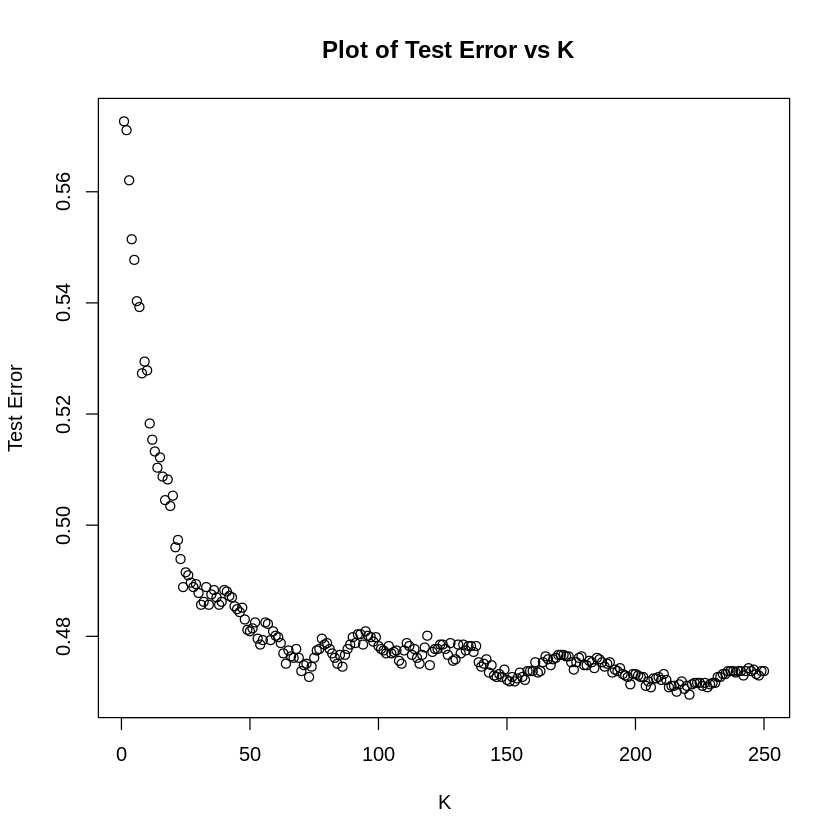

In [0]:

plot(x = 1:250, y = 1-knn_pred_mean, main = " Plot of Test Error vs K", ylab = "Test Error", xlab = "K")

In [0]:
mink <- which.max(knn_pred_mean)
knn_pred <- knn(x_train, x_test,y_train, k=mink) 
table(knn_pred, y_test)
accuracy = mean(knn_pred==y_test)


        y_test
knn_pred Draw Home Away
    Draw    2    4    2
    Home  723 1529  650
    Away  217  176  467

## Odds predicting stuff<a name="odds"></a>
[(back to top)](#top)

### Problem Formulation<a name="form-odds"></a>
[(back to top)](#top)

Now to see what bookie is most accurate in predictions:

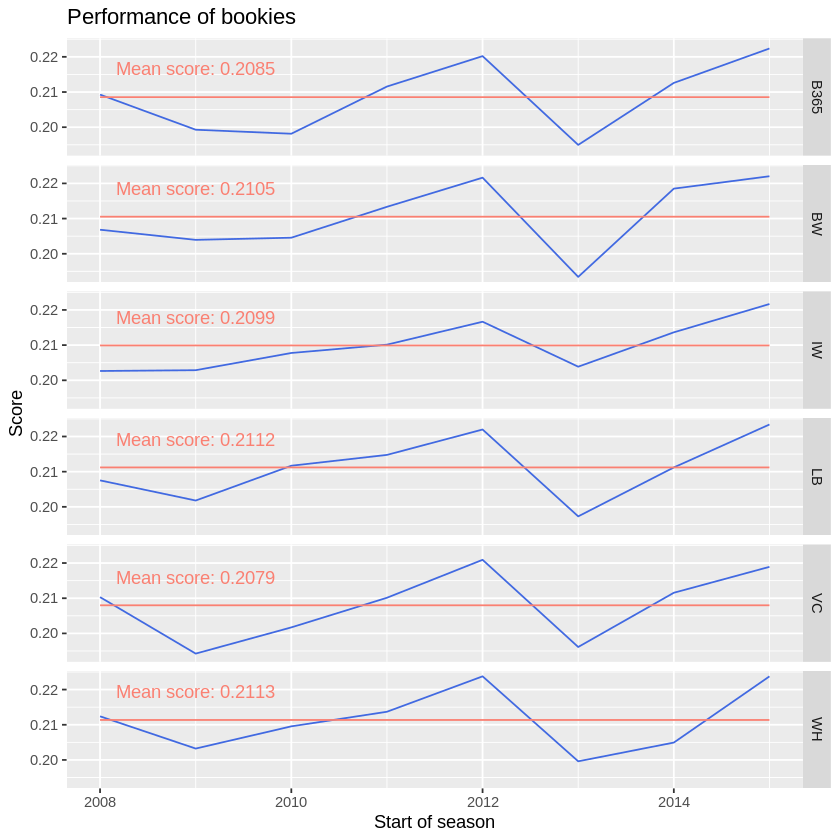

In [0]:
# Select necessary columns
df_bookies <- dfs[[2]] %>% 
    mutate(winner=home_team_goal-away_team_goal) %>% 
    mutate(winner=ifelse(winner==0, "Draw", 
                         ifelse(winner>0, "Home", "Away"))) %>% 
    mutate(winner=factor(winner, levels=c("Draw", "Home", "Away"))) %>% 
    select(season_start, starts_with("B365"), starts_with("BW"), 
           starts_with("IW"), starts_with("LB"), starts_with("VC"), 
           starts_with("WH"), winner) %>% 
    drop_na()

# Evaluate performance of each bookie over time
bookie_names <- names(df_bookies)
df_scores <- data.frame("season_start"=integer(), "score"=integer(), 
                        "bookie"=character())
for (i in 1:6){
    idx <- (3*(i-1))+2
    
    bookie <- df_bookies %>% 
        select(season_start, Home=bookie_names[idx], 
               Draw=bookie_names[idx+1], Away=bookie_names[idx+2], winner)
    bookie <- bookie %>% 
        mutate(bet=names(bookie[, c("Draw", "Away", "Home")])[max.col(bookie[, c("Draw", "Away", "Home")], "first")]) %>%
        mutate(correct_choice=(bet == winner)) %>% 
        group_by(season_start) %>% 
        summarise(score=mean(correct_choice)) %>% 
        mutate(bookie=str_sub(bookie_names[idx], 1, -2)) %>% 
        mutate(mean_score=mean(score))
        
    df_scores <- rbind(df_scores, bookie)
}

df_text <- data.frame(x=2009, y=df_scores$mean_score+0.008, bookie=df_scores$bookie, 
                      lab=paste("Mean score:", df_scores$mean_score)) %>% 
    mutate(lab=str_sub(lab, 1, 18)) %>% 
    distinct
    
ggplot(df_scores) + 
    geom_line(aes(x=season_start, y=score), col="royal blue") + 
    geom_line(aes(x=season_start, y=mean_score), col="salmon") + 
    geom_text(mapping=aes(x=x, y=y, label=lab), data=df_text, col="salmon") + 
    facet_grid(bookie~.) + 
    ggtitle("Performance of bookies") + 
    xlab("Start of season") + 
    ylab("Score")

From the results it looks like all bookies with minimal NA values correctly predict around the same amount of matches each season. As such, since B365 is the bookie with the least NA values I think that bookie (bet-365) would be the best to use in our models.

In [0]:
df <-dfs[[2]][, c(1:76, 85:87)]#finn, keeping B365 odds in there

df <- df[complete.cases(df), ]

# Join Team_Attributes table
df_team <- dfs[[6]] %>% 
    select(-c(id, date, team_fifa_api_id))
df_home <- df_team
names(df_home) <- paste0(names(df_home), "Home")
df_away <- df_team
names(df_away) <- paste0(names(df_away), "Away")

df <- df %>% 
    inner_join(df_home, by=c("home_team_api_id"="team_api_idHome")) %>% 
    inner_join(df_away, by=c("away_team_api_id"="team_api_idAway"))

# Join Player_Attributes table
df_player <- dfs[[4]] %>% 
    select(-c(id, date, player_fifa_api_id))
player_names <- names(df_player)
for (i in 1:11) {
    # Dynamically create named vector to match joining columns
    home_key <- paste0("home_player_", i)
    join_home <- paste0("player_api_id_home_", i)
    away_key <- paste0("away_player_", i)
    join_away <- paste0("player_api_id_away_", i)
    names(join_home) <- home_key
    names(join_away) <- away_key

    # Join tables
    names(df_player) <- paste0(player_names, "_home_", i)
    df <- inner_join(df, df_player, by=join_home)
    names(df_player) <- paste0(player_names, "_away_", i)
    df <- inner_join(df, df_player, by=join_away)
}

# Replace country_id with country_name
df_country <- dfs[[1]] %>% 
    select(country_id, country_name)
df <- df %>% 
    inner_join(df_country, by="country_id")

# Convert home_team_goal and away_team_goal into a single column
df <- df %>% 
    mutate(winner=home_team_goal-away_team_goal) %>% 
    mutate(winner=ifelse(winner==0, "Draw", 
                         ifelse(winner>0, "Home", "Away")))

# Remove columns unnecessary for prediction
to_remove <- c("id", "country_id", "date", "country_name", 
               "home_team_goal", "away_team_goal", "stage", 
               paste0(c("match", "home_team", "away_team"), "_api_id"), 
               paste0("home_player_", 1:11), paste0("away_player_", 1:11), 
               paste0("home_player_X", 1:11), paste0("away_player_X", 1:11), 
               paste0("home_player_Y", 1:11), paste0("away_player_Y", 1:11))
df <- select(df, -to_remove)

print('number rows with B365')
print(nrow(df))

[1] "number rows with B365"
[1] 17472


In [0]:
# Set aside target variable
y <- factor(df$winner, levels=c("Draw", "Home", "Away"))

# Convert character columns in factors
df_ctgy <- df %>% 
    select(-winner) %>% 
    select_if(is.character) %>% 
    mutate_all(as.factor)

# Scale continuous features to [0, 1]
df_cont <- df %>% 
    select_if(function(y) is.integer(y) | is.double(y)) %>% 
    mutate_all(function(x) (x - min(x)) / (max(x) - min(x)))
cont_features <- names(df_cont)

# Dummy encode categorical features
mat_ctgy <- model.matrix(~., df_ctgy)
mat_ctgy <- mat_ctgy[, 2:ncol(mat_ctgy)]

# Combine into data frame
df_final <- cbind(df_cont, mat_ctgy, winner=y) %>% 
    as_tibble
id <- 1:nrow(df_final)#finn included this to allow for indexing of rows
ctgy_features <- setdiff(names(df_final), cont_features) %>% 
    setdiff("winner")

# Get split indices
train_prop <- 0.8
train_size <- floor(train_prop * nrow(df_final))
train_ind <- sample(1:nrow(df_final), size=train_size)

# Split data frame
df_train <- df_final[train_ind,]
df_test <- df_final[-train_ind,]
id_test <- id[-train_ind]#finn included this to allow for indexing of rows

df_cont <- df_train %>% 
    select(cont_features)

### Dimensionality Reduction<a name="dim_red-odds"></a>

#### Principal Component Analysis<a name="pca-odds"></a>
[(back to top)](#top)

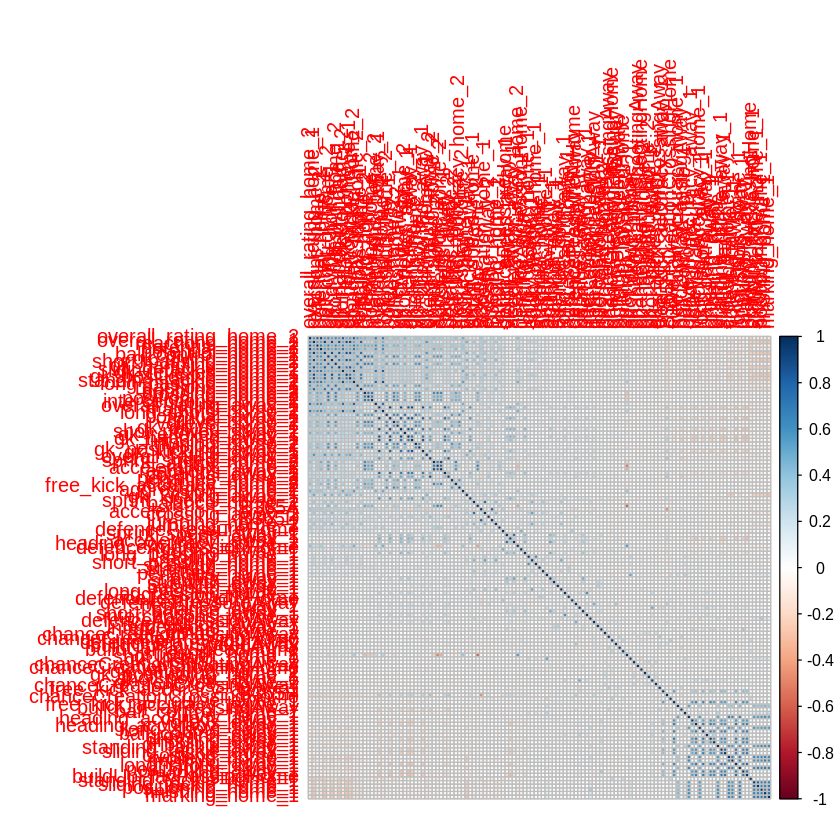

In [0]:
corrplot(cor(df_cont[, 1:50]), order="hclust", addrect=8)

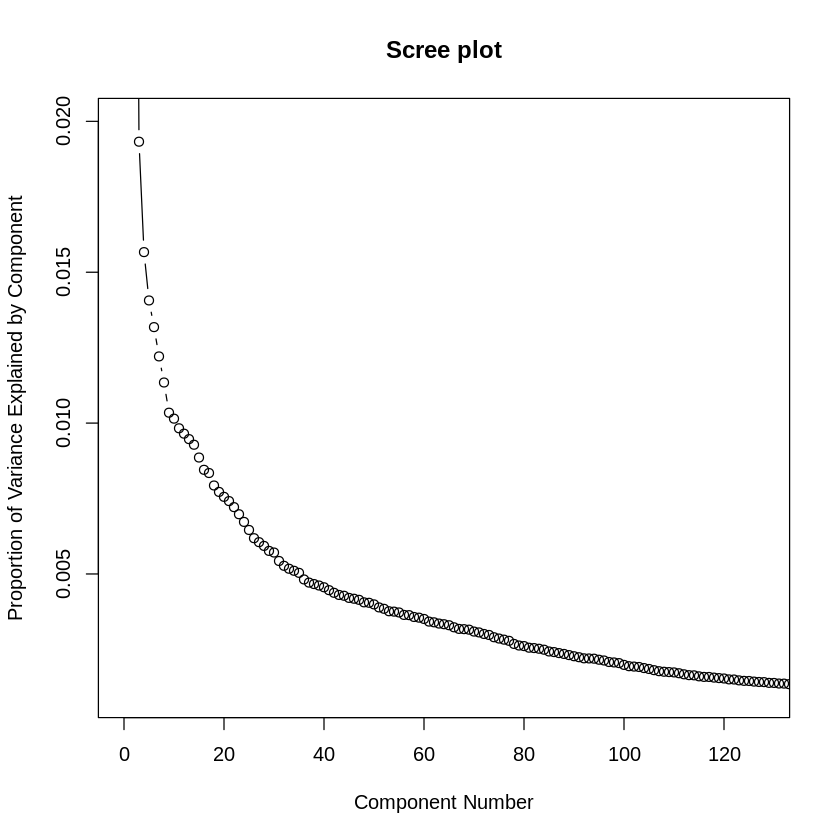

In [0]:
# Create PCA model
pca_model <- prcomp(df_cont, scale.=TRUE)

# Create scree plot
pr_var <- pca_model$sdev^2
prop_var_explained <- pr_var/sum(pr_var)
plot(prop_var_explained, 
    main="Scree plot", 
    xlab="Component Number", 
    ylab="Proportion of Variance Explained by Component", 
    xlim=c(0, 128), 
    ylim=c(0.001, 0.02), 
    type="b")

In [0]:
num_comp <- 35
mat_cont <- pca_model$x[, 1:num_comp]

# Reduced training dataset
df_ctgy <- df_train %>% 
    select(ctgy_features)
df_red_train <- cbind(mat_cont, df_ctgy, winner=df_train$winner) %>% 
    as_tibble

# Reduce testing dataset
df_cont <- df_test %>% 
    select(cont_features)
mat_cont <- predict(pca_model, newdata=df_cont)[, 1:num_comp]
df_ctgy <- df_test %>% 
    select(ctgy_features)
df_red_test <- cbind(mat_cont, df_ctgy, winner=df_test$winner) %>% 
    as_tibble

### Multiclass Classification<a name="class-odds"></a>

#### Multinomial Logistic Regression<a name="mlr-odds"></a>
[(back to top)](#top)

In [0]:

start_time <- Sys.time()
mlr_model <- multinom(winner~., data=df_train, maxit=1024, MaxNWts=10000)
end_time <- Sys.time()
writeLines(paste("Time taken:", end_time-start_time, "min\n"))

start_time <- Sys.time()
mlr_red_model <- multinom(winner~., data=df_red_train, maxit=1024, MaxNWts=10000)
end_time <- Sys.time()
writeLines(paste("Time taken:", end_time-start_time, "sec"))
#save(mlr_model, file = "./tmp/model_multinom.rda")#finn made it so you can save the model 
#mlr_model <- get(load(file = "./tmp/model_multinom.rda"))#finn made it so you can save the model (: (:(:

# weights:  303 (200 variable)
initial  value 15355.303959 
iter  10 value 14302.863081
iter  20 value 14255.491152
iter  30 value 14227.879693
iter  40 value 14189.404126
iter  50 value 14123.659059
iter  60 value 14000.270827
iter  70 value 13896.400937
iter  80 value 13792.754481
iter  90 value 13725.933330
iter 100 value 13617.997366
iter 110 value 13522.321629
iter 120 value 13432.305040
iter 130 value 13402.763707
iter 140 value 13391.874525
iter 150 value 13390.477342
iter 160 value 13389.995913
iter 170 value 13389.867419
iter 180 value 13389.841470
iter 190 value 13389.832299
final  value 13389.831150 
converged


In [0]:
message <- "TRAIN SCORE\nF1 score:"
y_pred <- predict(mlr_model, type="class", newdata=df_train)
writeLines(paste(message, F1_Score(y_pred, df_train$winner)))
confusionMatrix(y_pred, df_train$winner)

message <- "-----------------------------------------------------------------\n
TEST SCORE\nF1 score:"
y_pred <- predict(mlr_model, type="class", newdata=df_test)
writeLines(paste(message, F1_Score(y_pred, df_test$winner)))
confusionMatrix(y_pred, df_test$winner)

F1-score: 0.0579110651499483


Confusion Matrix and Statistics

          Reference
Prediction Draw Home Away
      Draw   28   24   26
      Home  591 1317  445
      Away  270  286  508

Overall Statistics
                                          
               Accuracy : 0.5302          
                 95% CI : (0.5135, 0.5468)
    No Information Rate : 0.4655          
    P-Value [Acc > NIR] : 1.129e-14       
                                          
                  Kappa : 0.2112          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: Draw Class: Home Class: Away
Sensitivity             0.031496      0.8095      0.5189
Specificity             0.980814      0.4454      0.7790
Pos Pred Value          0.358974      0.5597      0.4774
Neg Pred Value          0.748025      0.7285      0.8063
Prevalence              0.254363      0.4655      0.2801
Detection Rate          0.008011      0.3768      0.1454
Detection Prev

###Random Forest Classifier

In [0]:
# SINGLE TREE MODEL

#Probably need to install rpart in the beginning?
#import rpart
p_load("rpart")

#Build a classification tree based on the training data. We set the complexity parameter (cp) to zero to let the tree fit the training data as well as possible
tree = rpart(factor(df_train$winner)~., df_train, method = 'class', control = list(cp=0))

#generally the tree will overfit the training data, so we now do a cross-validation and prune the tree based on the best value of cp (will be >0)
plotcp(tree)
ptree<- prune(tree,cp= tree$cptable[which.min(tree$cptable[,"xerror"]),"CP"])

# the package rattle can be used to make a nice visualization of the tree with fancyRpartPlot
#should also be installed in the beginning
p_load("rattle")
fancyRpartPlot(ptree)

# Now lets see how well the pruned tree does on the test data.
ptree_preds = predict(ptree, df_test, type='class')
ptree_confmat <- confusionMatrix(ptree_preds, factor(df_test$winner))
ptree_byclass = ptree_confmat$byClass
sprintf("Tree Avarage Balance Accuracy: %s", sum(ptree_byclass[,"Balanced Accuracy"])/3)

In [0]:
# NOW THE RANDOM FOREST
# the random forest is implemented with the package ranger.
# ranger must also be installed
p_load("ranger")

# initialize some lists which will store some performance metrics of random forests models with different sizes
balanced_accuracy = c()
ntrees = c()
error_rate = c()

# start with creating a random forest with only one tree and evaluate its performance
BRF <- ranger(factor(df_train$winner)~., df_train, case.weights=weights, num.trees = 1)
BRF_preds = predict(BRF, data = df_test)
BRF_confmat <- confusionMatrix(BRF_preds$predictions, factor(df_test$winner))
BRF_byclass = BRF_confmat$byClass
sprintf("Balanced random forest %s Trees Avarage Balance Accuracy: %s", 1, sum(BRF_byclass[,"Balanced Accuracy"])/3)
balanced_accuracy = c(balanced_accuracy, sum(BRF_byclass[,"Balanced Accuracy"])/3)
ntrees = c(ntrees, 1)
error_rate = c(error_rate, 1-BRF_confmat$overall["Accuracy"])

# Now train and evaluate random forests with ntrees = i*20 with i ranging from 1 to 30.
# We can then plot the error_rate against ntrees
for(i in 1:30){
  BRF <- ranger(factor(df_train$winner)~., df_train, case.weights=weights, num.trees = i*20)
  BRF_preds = predict(BRF, data = df_test)
  BRF_confmat <- confusionMatrix(BRF_preds$predictions, factor(df_test$winner))
  BRF_byclass = BRF_confmat$byClass
  sprintf("Balanced random forest %s Trees Avarage Balance Accuracy: %s", 20*i, sum(BRF_byclass[,"Balanced Accuracy"])/3)
  balanced_accuracy = c(balanced_accuracy, sum(BRF_byclass[,"Balanced Accuracy"])/3)
  ntrees = c(ntrees, 20*i)
  error_rate = c(error_rate, 1-BRF_confmat$overall["Accuracy"])
}

**Compare Model to Betting odds:**

*I think the confusion matrices are a bit big. Can minimize them when we go to presentation stage.*



**About the cell below**
The cell below allows for creating confusion matrices to compare the bookies prediction accuracy with our multinomial logistic regression model. There are confusion matrices for the average bookie prediction per match and then the actual predictions for B365 bookie. This is to allow for understanding of how a singular bookie may match up with our model. 

**To include in presentation:**
How Bookie odds were converted to probabilities:
Bookies are known to increase their odds to increase their returns so they are bound to make a profit in the long run. This extra amount is unknown, it is either a flat or scaled commission. Since this is only for analysis (the exact method can be deduced when it is relevant) we assume more simple method, the commission is flat. 
As such, for each bookies odds per match we calculate probabiltiy by transforming the odds using p=odds/(odds+1) and then scale the probabilities to sum to 1. These probabilties are now still proportional to the odds and can be directly compared with the model's predictions for each class. 


In [0]:
#make a clean function to get the predictions for bookies, model and their results. 
#I want to get confusion matrix, ROC, brier score for b365 vs model and a mix of all bookies (maybe except the ones with lots of na's)
y_pred_probs <- predict(mlr_model, type="probs", newdata=df_test)
y_pred_odds <- as_tibble(y_pred_probs) %>% 
    mutate(ID=row_number())

bookie_df <- dfs[[2]][85:length(colnames(dfs[[2]]))]
bookieodds_test_2 <- bookie_df[id_test, 1:length(bookie_df)]
bookieodds_test_2$ID <- 1:nrow(bookieodds_test_2)
#add test column to above, then remove na rows then separate test column to use thereafter
bookieodds_test_2 <- bookieodds_test_2 %>% add_column(y_test) %>% 
    left_join(y_pred_odds, by="ID") %>% 
    drop_na()
y_test_bookie <- bookieodds_test_2 %>% 
    select(y_test, ID)
y_pred_odds_bookie <- bookieodds_test_2 %>% 
    select(Draw, Home, Away, ID)
bookieodds_test_2 <- bookieodds_test_2 %>% 
    select(-c(Draw,Home, Away,y_test)) 

bet_model <-y_pred_odds_bookie %>%
    mutate(model_bet=names(y_pred_odds_bookie[,c("Draw", "Away", "Home")])[max.col(y_pred_odds_bookie[,c("Draw", "Away", "Home")], "first")]) %>%
    add_column(match_result=y_test_bookie$y_test) %>% 
    mutate(model_Bool=if_else(model_bet == match_result, TRUE, FALSE)) %>%
    select(-match_result) %>% rename(model_draw=Draw, model_home=Home, model_away=Away)

sum_to_1_home <- function(Home, Draw, Away) {
    #NA's seem to have all been removed so not a problem
    return ((Home) / (Home + Draw + Away))
}
sum_to_1_away <- function(Home, Draw, Away) {
    #if na remove 
    return ((Away) / (Home + Draw + Away))
}
sum_to_1_draw <- function(Home, Draw, Away) {
    #if na remove 
    return ((Draw) / (Home + Draw + Away))
}

# maybe use this instead
normalize <- function(x) {
    return(x/(1+x))
}
df_list <- list()

for (i in 1:10){
    
    indx1 <- (3*(i-1))+1#LOL
    indx2 <- (i*3)

    bookieodds_test <- bookieodds_test_2[ ,indx1:indx2] %>% add_column(ID=bookieodds_test_2$ID)
    bookieodds_norm <- bookieodds_test %>% 
                mutate(Home_decimal_odds = normalize(bookieodds_test[1])[[1]], 
                  Draw_decimal_odds=normalize(bookieodds_test[2])[[1]], 
                  Away_decimal_odds=normalize(bookieodds_test[3])[[1]]) %>%
                transmute(Home = sum_to_1_home(Home_decimal_odds, Draw_decimal_odds, Away_decimal_odds), 
                  Draw=sum_to_1_draw(Home_decimal_odds, Draw_decimal_odds, Away_decimal_odds), 
                  Away=sum_to_1_away(Home_decimal_odds, Draw_decimal_odds, Away_decimal_odds), ID=ID) 

    bets <- bookieodds_norm# %>% 
        #mutate(pred_Draw=y_pred_odds_bookie$Draw, pred_Home=y_pred_odds_bookie$Home, 
        #pred_Away=y_pred_odds_bookie$Away)
    
    df_name <- str_sub(names(bookieodds_test[1]), 1, -2)
    if (df_name=='B365') {
        B365_df <- bookieodds_norm %>% mutate(bookie_bet=names(bookieodds_norm[,c("Draw", "Away", "Home")])[max.col(bookieodds_norm[,c("Draw", "Away", "Home")], "first")]) %>%
            add_column(match_result=y_test_bookie$y_test) %>% 
            mutate(bookie_Bool=if_else(bookie_bet == match_result, TRUE, FALSE)) %>%
            left_join(bet_model, by="ID")
    }
    df_list[[df_name]] <- bets
}
model_bookie_df <- bind_rows(df_list, .id="df")
#find average of bookie probabilities for each match 
#want to do this and then find the predicted outcome from the *average* probability. This means that the confusion matrix won't 
#show the actual preictions of each respective bookie, but it will allow us to compare the average bookies prediction statistics, 
#which we couldn't do otherwise. Also the B365 confusion matrix will show the exact bets of the b365 bookies.
all_bookies_mean_df <- model_bookie_df %>%
  group_by(ID) %>%
  summarise(Home=mean(Home), Draw=mean(Draw), Away=mean(Away))
#, m_pred_Home=mean(pred_Home), m_pred_Away=mean(pred_Away)

bookie_model_df <- all_bookies_mean_df %>% 
    mutate(bookie_bet=names(all_bookies_mean_df[,c("Draw", "Away", "Home")])[max.col(all_bookies_mean_df[,c("Draw", "Away", "Home")], "first")]) %>%
    add_column(match_result=y_test_bookie$y_test) %>% 
    mutate(bookie_Bool=if_else(bookie_bet == match_result, TRUE, FALSE)) %>%
    left_join(bet_model, by="ID")


In [0]:


#glimpse(bet_bookie)
#glimpse(B365_df)
bookie_model_df <- mutate_if(bookie_model_df, is.character, as.factor)
B365_df <- mutate_if(B365_df, is.character, as.factor)

print("Confusion matrix for all bookie predictions vs reference")
confusionMatrix(bookie_model_df$bookie_bet, bookie_model_df$match_result)
print("Confusion matrix for multinomial logistic regression model vs reference")
confusionMatrix(bookie_model_df$model_bet, bookie_model_df$match_result)
print("Confusion matrix for multinomial logistic regression model vs reference")
confusionMatrix(B365_df$model_bet, B365_df$match_result)
print("Confusion matrix for B365 bookie predictions vs reference")
confusionMatrix(B365_df$bookie_bet, B365_df$match_result)

Woah you can see from the above that our model is a lot better than the bookies. Perhaps it could be used to beat the bookies? (fun!$$$)

## Appendix<a name="appendix"></a>
[(back to top)](#top)

B365H = Bet365 home win odds

B365D = Bet365 draw odds

B365A = Bet365 away win odds

BSH = Blue Square home win odds

BSD = Blue Square draw odds

BSA = Blue Square away win odds

BWH = Bet&Win home win odds

BWD = Bet&Win draw odds

BWA = Bet&Win away win odds

GBH = Gamebookers home win odds

GBD = Gamebookers draw odds

GBA = Gamebookers away win odds

IWH = Interwetten home win odds

IWD = Interwetten draw odds

IWA = Interwetten away win odds

LBH = Ladbrokes home win odds

LBD = Ladbrokes draw odds

LBA = Ladbrokes away win odds

PSH and PH = Pinnacle home win odds

PSD and PD = Pinnacle draw odds

PSA and PA = Pinnacle away win odds

SOH = Sporting Odds home win odds

SOD = Sporting Odds draw odds

SOA = Sporting Odds away win odds

SBH = Sportingbet home win odds

SBD = Sportingbet draw odds

SBA = Sportingbet away win odds

SJH = Stan James home win odds

SJD = Stan James draw odds

SJA = Stan James away win odds

SYH = Stanleybet home win odds

SYD = Stanleybet draw odds

SYA = Stanleybet away win odds

VCH = VC Bet home win odds

VCD = VC Bet draw odds

VCA = VC Bet away win odds

WHH = William Hill home win odds

WHD = William Hill draw odds

WHA = William Hill away win odds